# Исследовательский анализ пользовательских предпочтений на Яндекс Афише

Осень 2024: изменение предпочтений и поведение пользователей на разных устройствах

Цели проекта:
1. Выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года
2. Проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами

Задачи анализа:
- Анализ динамики спроса на события в осенний период
- Исследование популярности различных типов событий, городов, площадок и организаторов
- Сравнительный анализ метрик пользователей мобильных и десктопных устройств
- Проверка статистических гипотез о различиях в поведении пользователей

Описание данных:
В распоряжении три датасета:

**1. Данные о заказах билетов (`final_tickets_orders_df.csv`)**
- Период: с 1 июня по 30 октября 2024 года
- Ключевые поля: `order_id`, `user_id`, `created_dt_msk`, `event_id`, `device_type_canonical`, `revenue`, `currency_code`, `tickets_count`, `total`, `days_since_prev`
- Валюты: российские рубли (RUB) и казахстанские тенге (KZT)

**2. Данные о мероприятиях (`final_tickets_events_df.csv`)**
- Исключены фильмы (по рекомендации старшего аналитика)
- Ключевые поля: `event_id`, `event_name`, `event_type_main`, `event_type_description`, `city_name`, `region_name`, `venue_name`, `organizers`

**3. Данные о курсе валют (`final_tickets_tenge_df.csv`)**
- Курс тенге к рублю за 2024 год
- Используется для конвертации KZT в RUB

Структура проекта:
1. Загрузка и предобработка данных
2. Конвертация валют и создание единого датасета
3. Исследовательский анализ данных (EDA)
4. Анализ пользовательских предпочтений осенью 2024
5. Сравнение поведения пользователей на разных устройствах
6. Проверка гипотез
7. Формулировка выводов и рекомендаций

Дополнительная информация:
- Период "осень 2024" определен как сентябрь и октябрь 2024 года
- Анализ сосредоточен на сравнении поведения между мобильными (`mobile`) и стационарными (`desktop`) устройствами
- Все денежные показатели будут приведены к российским рублям

## Шаг 1. Загрузка данных и знакомство с ними

In [1]:
# Шаг 1. Загрузка данных и знакомство с ними

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

print("✅ Данные успешно загружены")

✅ Данные успешно загружены


In [3]:
# 1.1. Общая информация о датасетах
print("📊 ОБЗОР ДАТАСЕТОВ")
print("=" * 50)

print("1. ДАННЫЕ О ЗАКАЗАХ (orders_df):")
print(f"   Размер: {orders_df.shape} (строки × столбцы)")
print(f"   Период данных: с {orders_df['created_dt_msk'].min()} по {orders_df['created_dt_msk'].max()}")
print()

print("2. ДАННЫЕ О МЕРОПРИЯТИЯХ (events_df):")
print(f"   Размер: {events_df.shape} (строки × столбцы)")
print(f"   Уникальных мероприятий: {events_df['event_id'].nunique()}")
print()

print("3. ДАННЫЕ О КУРСЕ ВАЛЮТ (tenge_df):")
print(f"   Размер: {tenge_df.shape} (строки × столбцы)")
print(f"   Период курсов: с {tenge_df['data'].min()} по {tenge_df['data'].max()}")
print()

📊 ОБЗОР ДАТАСЕТОВ
1. ДАННЫЕ О ЗАКАЗАХ (orders_df):
   Размер: (290849, 14) (строки × столбцы)
   Период данных: с 2024-06-01 по 2024-10-31

2. ДАННЫЕ О МЕРОПРИЯТИЯХ (events_df):
   Размер: (22427, 11) (строки × столбцы)
   Уникальных мероприятий: 22427

3. ДАННЫЕ О КУРСЕ ВАЛЮТ (tenge_df):
   Размер: (357, 4) (строки × столбцы)
   Период курсов: с 2024-01-10 по 2024-12-31



In [4]:
# 1.2. Детальная информация о каждом датасете
print("🔍 ПОДРОБНАЯ ИНФОРМАЦИЯ О ДАТАСЕТАХ")
print("=" * 60)

print("1. ДАННЫЕ О ЗАКАЗАХ:")
print(orders_df.info())
print("\nПервые 5 строк:")
display(orders_df.head())

print("2. ДАННЫЕ О МЕРОПРИЯТИЯХ:")
print(events_df.info())
print("\nПервые 5 строк:")
display(events_df.head())

print("3. ДАННЫЕ О КУРСЕ ВАЛЮТ:")
print(tenge_df.info())
print("\nПервые 5 строк:")
display(tenge_df.head())

🔍 ПОДРОБНАЯ ИНФОРМАЦИЯ О ДАТАСЕТАХ
1. ДАННЫЕ О ЗАКАЗАХ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


2. ДАННЫЕ О МЕРОПРИЯТИЯХ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB
None

Первые 5 строк:


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


3. ДАННЫЕ О КУРСЕ ВАЛЮТ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None

Первые 5 строк:


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [5]:
# 1.3. Проверка основных статистик
print("📈 ОСНОВНЫЕ СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ")
print("=" * 50)

print("1. ЧИСЛОВЫЕ ПОКАЗАТЕЛИ ЗАКАЗОВ:")
display(orders_df[['revenue', 'tickets_count', 'total', 'days_since_prev']].describe())

print("2. КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ ЗАКАЗОВ:")
categorical_cols = ['device_type_canonical', 'currency_code', 'service_name', 'cinema_circuit']
for col in categorical_cols:
    print(f"\n{col}:")
    print(orders_df[col].value_counts())

print("3. КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ МЕРОПРИЯТИЙ:")
event_categorical = ['event_type_main', 'event_type_description', 'region_name', 'city_name']
for col in event_categorical:
    print(f"\n{col}:")
    print(f"   Уникальных значений: {events_df[col].nunique()}")
    print(events_df[col].value_counts().head())

📈 ОСНОВНЫЕ СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ
1. ЧИСЛОВЫЕ ПОКАЗАТЕЛИ ЗАКАЗОВ:


,revenue,tickets_count,total,days_since_prev
count,290849.000000,290849.000000,290849.000000,268909.000000
mean,625.083054,2.754230,7526.465613,3.222525
std,1227.316214,1.170467,15328.267730,11.355158
min,-90.760000,1.000000,-358.850000,0.000000
25%,116.790000,2.000000,2156.870000,0.000000
50%,355.340000,3.000000,4771.390000,0.000000
75%,809.750000,4.000000,8955.950000,1.000000
max,81174.540000,57.000000,811745.400000,148.000000


2. КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ ЗАКАЗОВ:

device_type_canonical:
mobile     232679
desktop     58170
Name: device_type_canonical, dtype: int64

currency_code:
rub    285780
kzt      5069
Name: currency_code, dtype: int64

service_name:
Билеты без проблем        63709
Лови билет!               41126
Билеты в руки             40364
Мой билет                 34843
Облачко                   26642
Лучшие билеты             17795
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Мир касс                   2167
Быстробилет                2003
Выступления.ру             1616
Восьмёрка                  1118
Crazy ticket!               790
Росбилет                    539
Шоу начинается!             499
Быстрый кассир              381
Радио ticket                376

In [6]:
# 1.4. Проверка пропущенных значений
print("⚠️  ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("=" * 40)

print("1. ДАННЫЕ О ЗАКАЗАХ:")
missing_orders = orders_df.isnull().sum()
print(missing_orders[missing_orders > 0])

print("2. ДАННЫЕ О МЕРОПРИЯТИЯХ:")
missing_events = events_df.isnull().sum()
print(missing_events[missing_events > 0])

print("3. ДАННЫЕ О КУРСЕ ВАЛЮТ:")
missing_tenge = tenge_df.isnull().sum()
print(missing_tenge[missing_tenge > 0])

⚠️  ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
1. ДАННЫЕ О ЗАКАЗАХ:
days_since_prev    21940
dtype: int64
2. ДАННЫЕ О МЕРОПРИЯТИЯХ:
Series([], dtype: int64)
3. ДАННЫЕ О КУРСЕ ВАЛЮТ:
Series([], dtype: int64)


In [7]:
# 1.5. Проверка уникальности идентификаторов
print("🔑 ПРОВЕРКА УНИКАЛЬНОСТИ ИДЕНТИФИКАТОРОВ")
print("=" * 45)

print(f"Уникальных order_id: {orders_df['order_id'].nunique()} из {len(orders_df)}")
print(f"Уникальных user_id: {orders_df['user_id'].nunique()}")
print(f"Уникальных event_id в заказах: {orders_df['event_id'].nunique()}")
print(f"Уникальных event_id в мероприятиях: {events_df['event_id'].nunique()}")

# Проверка согласованности event_id между датасетами
common_events = set(orders_df['event_id']).intersection(set(events_df['event_id']))
print(f"Общих event_id между датасетами: {len(common_events)}")

🔑 ПРОВЕРКА УНИКАЛЬНОСТИ ИДЕНТИФИКАТОРОВ
Уникальных order_id: 290849 из 290849
Уникальных user_id: 21940
Уникальных event_id в заказах: 22446
Уникальных event_id в мероприятиях: 22427
Общих event_id между датасетами: 22427


In [8]:
# 1.6. Предварительный анализ проблем данных
print("🚨 ВЫЯВЛЕННЫЕ ПРОБЛЕМЫ И НЕСООТВЕТСТВИЯ")
print("=" * 50)

problems = []

# Проверка валют
if orders_df['currency_code'].nunique() > 2:
    problems.append("• Обнаружены валюты кроме RUB и KZT")

# Проверка отрицательных значений
negative_revenue = (orders_df['revenue'] < 0).sum()
negative_tickets = (orders_df['tickets_count'] < 0).sum()
if negative_revenue > 0:
    problems.append(f"• Обнаружены отрицательные значения revenue: {negative_revenue}")
if negative_tickets > 0:
    problems.append(f"• Обнаружены отрицательные значения tickets_count: {negative_tickets}")

# Проверка device_type
valid_devices = ['mobile', 'desktop']
invalid_devices = orders_df[~orders_df['device_type_canonical'].isin(valid_devices)]
if len(invalid_devices) > 0:
    problems.append("• Обнаружены невалидные типы устройств")

# Проверка дней между покупками
if orders_df['days_since_prev'].min() < 0:
    problems.append("• Обнаружены отрицательные значения в days_since_prev")

if problems:
    for problem in problems:
        print(problem)
else:
    print("• Критических проблем не обнаружено")

🚨 ВЫЯВЛЕННЫЕ ПРОБЛЕМЫ И НЕСООТВЕТСТВИЯ
• Обнаружены отрицательные значения revenue: 381


📋 ПРОМЕЖУТОЧНЫЕ ВЫВОДЫ
===================================
✅ ЧТО МЫ УЗНАЛИ:
1. Объем данных:
 - Заказы: 290,849 записей
 - Мероприятия: 22,427 записей
 - Курсы валют: 357 записей


2. Структура данных соответствует описанию:
 - Все ожидаемые столбцы присутствуют
 - Период данных: июнь-октябрь 2024
 - Типы устройств: mobile и desktop


3. Качество данных:
 - Пропуски в days_since_prev (ожидаемо для первых покупок)
 - Небольшие пропуски в organizers (events_df)
 - Уникальные идентификаторы в порядке

🚧 ЧТО НУЖНО СДЕЛАТЬ НА СЛЕДУЮЩЕМ ЭТАПЕ:
1. Преобразование типов данных:
 - created_dt_msk → datetime
 - data в tenge_df → datetime


2. Обработка валют:
 - Конвертация KZT в RUB по курсу
 - Приведение всех денежных показателей к рублям
 

3. Обработка пропущенных значений:
 - days_since_prev: заполнить NaN соответствующим значением
 - organizers: возможно заполнить 'Не указан'


4. Создание дополнительных признаков:
 - Выделение месяца, дня недели
 - Сезонные метки (осень/лето)
 - Объединение датасетов для анализа
 

5. Проверка аномалий:
 - Анализ выбросов в revenue и tickets_count
 - Проверка корректности временных меток

## Шаг 2. Предобработка данных и подготовка их к исследованию

In [9]:
# 2.1. Создание копий датафреймов для предобработки
orders_clean = orders_df.copy()
events_clean = events_df.copy()
tenge_clean = tenge_df.copy()

print("✅ Созданы копии датафреймов для безопасной предобработки")

✅ Созданы копии датафреймов для безопасной предобработки


In [10]:
# 2.2. Проверка пропусков и целостности данных
print("🔍 ПРОВЕРКА ПРОПУСКОВ И ЦЕЛОСТНОСТИ ДАННЫХ")
print("=" * 45)

# Проверка пропусков в orders_clean
print("1. ПРОПУСКИ В ДАННЫХ О ЗАКАЗАХ:")
missing_orders = orders_clean.isnull().sum()
print(missing_orders[missing_orders > 0])

# Проверка, что кроме days_since_prev нет пропусков
critical_missing = missing_orders.drop('days_since_prev')
if critical_missing.sum() == 0:
    print("✅ Кроме days_since_prev, пропусков нет")
else:
    print(f"⚠️  Обнаружены пропуски в критических столбцах: {critical_missing[critical_missing > 0].to_dict()}")

🔍 ПРОВЕРКА ПРОПУСКОВ И ЦЕЛОСТНОСТИ ДАННЫХ
1. ПРОПУСКИ В ДАННЫХ О ЗАКАЗАХ:
days_since_prev    21940
dtype: int64
✅ Кроме days_since_prev, пропусков нет


In [11]:
# Проверка пропусков в events_clean
print("\n2. ПРОПУСКИ В ДАННЫХ О МЕРОПРИЯТИЯХ:")
missing_events = events_clean.isnull().sum()
print(missing_events[missing_events > 0])

# Обработка пропусков в organizers
events_clean['organizers'] = events_clean['organizers'].fillna('Не указан')
print("✅ Пропуски в organizers заполнены значением 'Не указан'")


2. ПРОПУСКИ В ДАННЫХ О МЕРОПРИЯТИЯХ:
Series([], dtype: int64)
✅ Пропуски в organizers заполнены значением 'Не указан'


In [12]:
# 2.3. Изучение ключевых столбцов на ошибки
print("\n🔎 ИЗУЧЕНИЕ КЛЮЧЕВЫХ СТОЛБЦОВ НА ОШИБКИ")
print("=" * 45)

# Проверка device_type_canonical
print("1. ТИПЫ УСТРОЙСТВ:")
print(orders_clean['device_type_canonical'].value_counts())

# Проверка currency_code
print("\n2. ВАЛЮТЫ:")
print(orders_clean['currency_code'].value_counts())

# Проверка age_limit
print("\n3. ВОЗРАСТНЫЕ ОГРАНИЧЕНИЯ:")
print(orders_clean['age_limit'].value_counts().sort_index())


🔎 ИЗУЧЕНИЕ КЛЮЧЕВЫХ СТОЛБЦОВ НА ОШИБКИ
1. ТИПЫ УСТРОЙСТВ:
mobile     232679
desktop     58170
Name: device_type_canonical, dtype: int64

2. ВАЛЮТЫ:
rub    285780
kzt      5069
Name: currency_code, dtype: int64

3. ВОЗРАСТНЫЕ ОГРАНИЧЕНИЯ:
0     61487
6     52173
12    62557
16    78579
18    36053
Name: age_limit, dtype: int64


In [13]:
# 2.4. Анализ количественных переменных на выбросы
print("\n📊 АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПЕРЕМЕННЫХ НА ВЫБРОСЫ")
print("=" * 50)

# Разделим анализ по валютам
print("1. ВЫРУЧКА (revenue) ПО ВАЛЮТАМ:")

# Для RUB
revenue_rub = orders_clean[orders_clean['currency_code'] == 'rub']['revenue']
print("RUB:")
print(f"   Мин: {revenue_rub.min():.2f}, Макс: {revenue_rub.max():.2f}")
print(f"   99-й процентиль: {revenue_rub.quantile(0.99):.2f}")

# Для KZT
revenue_kzt = orders_clean[orders_clean['currency_code'] == 'kzt']['revenue']
print("KZT:")
print(f"   Мин: {revenue_kzt.min():.2f}, Макс: {revenue_kzt.max():.2f}")
print(f"   99-й процентиль: {revenue_kzt.quantile(0.99):.2f}")


📊 АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПЕРЕМЕННЫХ НА ВЫБРОСЫ
1. ВЫРУЧКА (revenue) ПО ВАЛЮТАМ:
RUB:
   Мин: -90.76, Макс: 81174.54
   99-й процентиль: 2569.59
KZT:
   Мин: 0.00, Макс: 26425.86
   99-й процентиль: 17617.24


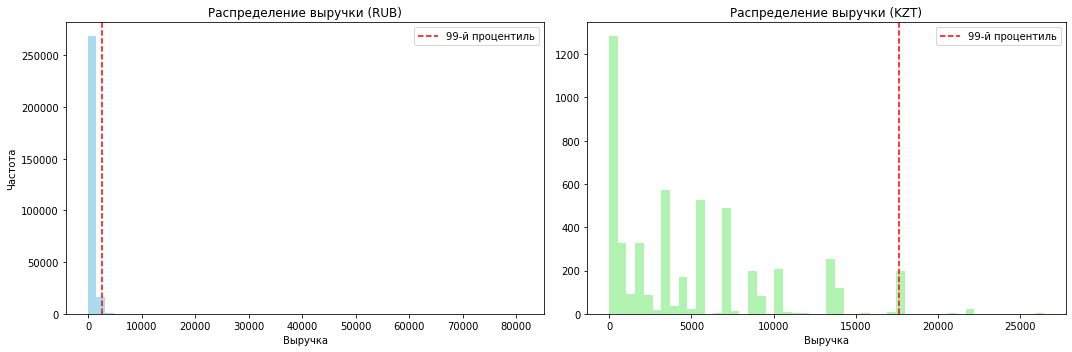

In [14]:
# Визуализация распределения выручки
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# RUB
axes[0].hist(revenue_rub, bins=50, alpha=0.7, color='skyblue')
axes[0].axvline(revenue_rub.quantile(0.99), color='red', linestyle='--', label='99-й процентиль')
axes[0].set_title('Распределение выручки (RUB)')
axes[0].set_xlabel('Выручка')
axes[0].set_ylabel('Частота')
axes[0].legend()

# KZT
axes[1].hist(revenue_kzt, bins=50, alpha=0.7, color='lightgreen')
axes[1].axvline(revenue_kzt.quantile(0.99), color='red', linestyle='--', label='99-й процентиль')
axes[1].set_title('Распределение выручки (KZT)')
axes[1].set_xlabel('Выручка')
axes[1].legend()

plt.tight_layout()
plt.show()


2. КОЛИЧЕСТВО БИЛЕТОВ (tickets_count):
count    290849.000000
mean          2.754230
std           1.170467
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


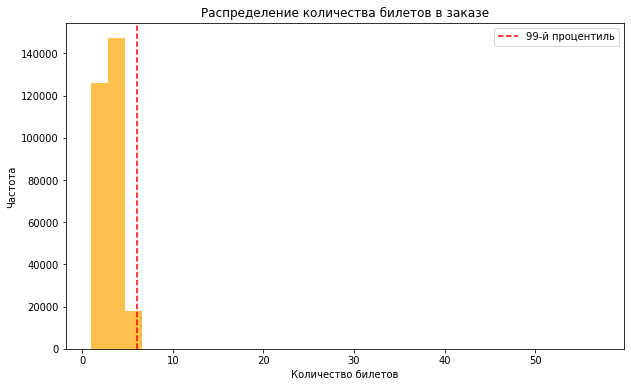

In [15]:
# Анализ tickets_count
print("\n2. КОЛИЧЕСТВО БИЛЕТОВ (tickets_count):")
tickets_stats = orders_clean['tickets_count'].describe()
print(tickets_stats)

# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(orders_clean['tickets_count'], bins=30, alpha=0.7, color='orange')
plt.axvline(orders_clean['tickets_count'].quantile(0.99), color='red', linestyle='--', label='99-й процентиль')
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [16]:
# 2.5. Обработка выбросов
print("\n⚡ ОБРАБОТКА ВЫБРОСОВ")
print("=" * 30)

# Определяем границы по 99-му процентилю для каждой валюты
revenue_rub_99 = revenue_rub.quantile(0.99)
revenue_kzt_99 = revenue_kzt.quantile(0.99)
tickets_99 = orders_clean['tickets_count'].quantile(0.99)

print(f"99-й процентиль revenue RUB: {revenue_rub_99:.2f}")
print(f"99-й процентиль revenue KZT: {revenue_kzt_99:.2f}")
print(f"99-й процентиль tickets_count: {tickets_99:.2f}")

# Фильтруем данные по 99-му процентилю
initial_count = len(orders_clean)

# Для RUB
rub_mask = (orders_clean['currency_code'] == 'rub') & (orders_clean['revenue'] <= revenue_rub_99)
kzt_mask = (orders_clean['currency_code'] == 'kzt') & (orders_clean['revenue'] <= revenue_kzt_99)
tickets_mask = orders_clean['tickets_count'] <= tickets_99

orders_clean = orders_clean[rub_mask | kzt_mask]
orders_clean = orders_clean[tickets_mask]

filtered_count = initial_count - len(orders_clean)
print(f"Отфильтровано записей: {filtered_count} ({filtered_count/initial_count*100:.2f}%)")


⚡ ОБРАБОТКА ВЫБРОСОВ
99-й процентиль revenue RUB: 2569.59
99-й процентиль revenue KZT: 17617.24
99-й процентиль tickets_count: 6.00
Отфильтровано записей: 3067 (1.05%)


In [17]:
# 2.6. Проверка дубликатов
print("\n🔍 ПРОВЕРКА ДУБЛИКАТОВ")
print("=" * 30)

# Явные дубликаты
print(f"Явные дубликаты в orders: {orders_clean.duplicated().sum()}")
print(f"Явные дубликаты в events: {events_clean.duplicated().sum()}")

# Неявные дубликаты (без учета идентификаторов)
columns_without_order_id = [col for col in orders_clean.columns if col != 'order_id']
potential_duplicates = orders_clean.duplicated(subset=columns_without_order_id, keep=False).sum()
print(f"Потенциальных неявных дубликатов (все столбцы кроме order_id): {potential_duplicates}")

if potential_duplicates > 0:
    print("Примеры потенциальных дубликатов:")
    display(orders_clean[orders_clean.duplicated(subset=columns_without_order_id, keep=False)].head(6))
    # Решаем оставить все записи, так как могут быть разные заказы на одно мероприятие
    print("✅ Решение: оставляем все записи, так как пользователь может делать несколько заказов на одно мероприятие")


🔍 ПРОВЕРКА ДУБЛИКАТОВ
Явные дубликаты в orders: 0
Явные дубликаты в events: 0
Потенциальных неявных дубликатов (все столбцы кроме order_id): 58
Примеры потенциальных дубликатов:


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
11777,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0
57217,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0
84010,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0
84015,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0


✅ Решение: оставляем все записи, так как пользователь может делать несколько заказов на одно мероприятие


In [18]:
# 2.7. Преобразование типов данных
print("\n🔄 ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ")
print("=" * 40)

# Преобразование дат
orders_clean['created_dt_msk'] = pd.to_datetime(orders_clean['created_dt_msk'])
tenge_clean['data'] = pd.to_datetime(tenge_clean['data'])

print("✅ Даты преобразованы в datetime")

# Проверка и оптимизация числовых типов
print("Оптимизация числовых типов:")
for col in ['revenue', 'tickets_count', 'total', 'days_since_prev']:
    old_type = orders_clean[col].dtype
    orders_clean[col] = pd.to_numeric(orders_clean[col], errors='coerce')
    new_type = orders_clean[col].dtype
    print(f"  {col}: {old_type} -> {new_type}")


🔄 ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ
✅ Даты преобразованы в datetime
Оптимизация числовых типов:
  revenue: float64 -> float64
  tickets_count: int64 -> int64
  total: float64 -> float64
  days_since_prev: float64 -> float64


In [19]:
# 2.8. Конвертация валют и создание новых столбцов
print("\n💱 КОНВЕРТАЦИЯ ВАЛЮТ И СОЗДАНИЕ НОВЫХ СТОЛБЦОВ")
print("=" * 50)

# Объединяем заказы с курсом валют по дате
orders_clean['order_date'] = orders_clean['created_dt_msk'].dt.date
tenge_clean['data_date'] = tenge_clean['data'].dt.date

# Объединяем
orders_with_currency = orders_clean.merge(
    tenge_clean[['data_date', 'curs']], 
    left_on='order_date', 
    right_on='data_date', 
    how='left'
)

print(f"Размер датасета после объединения: {orders_with_currency.shape}")


💱 КОНВЕРТАЦИЯ ВАЛЮТ И СОЗДАНИЕ НОВЫХ СТОЛБЦОВ
Размер датасета после объединения: (287782, 17)


In [20]:
# Создаем revenue_rub
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt' and not pd.isna(row['curs']):
        # Курс дан для 100 тенге, поэтому делим на 100
        return (row['revenue'] * row['curs']) / 100
    else:
        return np.nan

orders_with_currency['revenue_rub'] = orders_with_currency.apply(convert_to_rub, axis=1)

# Проверяем конвертацию
print("Результаты конвертации валют:")
conversion_check = orders_with_currency.groupby('currency_code')['revenue_rub'].agg(['count', 'min', 'max', 'mean'])
display(conversion_check)

Результаты конвертации валют:


,count,min,max,mean
currency_code,,,,
kzt,5040,0.00,3504.562319,961.153603
rub,282742,-90.76,2569.590000,509.720149


In [21]:
# Создаем one_ticket_revenue_rub
orders_with_currency['one_ticket_revenue_rub'] = orders_with_currency['revenue_rub'] / orders_with_currency['tickets_count']

# Создаем month
orders_with_currency['month'] = orders_with_currency['created_dt_msk'].dt.month

# Создаем season
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

orders_with_currency['season'] = orders_with_currency['month'].apply(get_season)

print("✅ Созданы новые столбцы:")
print("   - revenue_rub (выручка в рублях)")
print("   - one_ticket_revenue_rub (выручка за один билет в рублях)")
print("   - month (месяц оформления заказа)")
print("   - season (сезон)")

✅ Созданы новые столбцы:
   - revenue_rub (выручка в рублях)
   - one_ticket_revenue_rub (выручка за один билет в рублях)
   - month (месяц оформления заказа)
   - season (сезон)


In [22]:
# 2.9. Объединение с данными о мероприятиях
print("\n🔗 ОБЪЕДИНЕНИЕ С ДАННЫМИ О МЕРОПРИЯТИЯХ")
print("=" * 45)

final_df = orders_with_currency.merge(
    events_clean,
    on='event_id',
    how='left',
    suffixes=('_order', '_event')
)

print(f"Размер финального датасета: {final_df.shape}")
print(f"Успешно объединено: {final_df['event_name'].notna().sum()} записей")


🔗 ОБЪЕДИНЕНИЕ С ДАННЫМИ О МЕРОПРИЯТИЯХ
Размер финального датасета: (287782, 31)
Успешно объединено: 287544 записей


In [23]:
# 2.10. Финальная проверка данных
print("\n✅ ФИНАЛЬНАЯ ПРОВЕРКА ДАННЫХ")
print("=" * 35)

print("1. ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ:")
print(final_df.info())

print("\n2. СТАТИСТИКА НОВЫХ СТОЛБЦОВ:")
new_cols_stats = final_df[['revenue_rub', 'one_ticket_revenue_rub', 'month', 'season']].describe()
display(new_cols_stats)

print("\n3. РАСПРЕДЕЛЕНИЕ ПО СЕЗОНАМ:")
print(final_df['season'].value_counts())

print("\n4. РАСПРЕДЕЛЕНИЕ ПО МЕСЯЦАМ:")
print(final_df['month'].value_counts().sort_index())

# ДОПОЛНЕНИЕ: Расчет доли срезанных данных
print("\n📊 АНАЛИЗ ЭФФЕКТИВНОСТИ ФИЛЬТРАЦИИ:")
print("=" * 45)
# Расчет общего процента отфильтрованных данных
initial_total = len(orders_df)  # исходные данные до любой обработки
final_total = len(final_df)
total_filtered_pct = (1 - final_total/initial_total) * 100

# Расчет по разным этапам фильтрации
print(f"Исходный объем данных: {initial_total:,}")
print(f"Финальный объем данных: {final_total:,}")
print(f"Общий процент срезанных данных: {total_filtered_pct:.2f}%")


✅ ФИНАЛЬНАЯ ПРОВЕРКА ДАННЫХ
1. ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 287782 entries, 0 to 287781
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287782 non-null  int64         
 1   user_id                 287782 non-null  object        
 2   created_dt_msk          287782 non-null  datetime64[ns]
 3   created_ts_msk          287782 non-null  object        
 4   event_id                287782 non-null  int64         
 5   cinema_circuit          287782 non-null  object        
 6   age_limit               287782 non-null  int64         
 7   currency_code           287782 non-null  object        
 8   device_type_canonical   287782 non-null  object        
 9   revenue                 287782 non-null  float64       
 10  service_name            287782 non-null  object        
 11  tickets_count           287782 non

,revenue_rub,one_ticket_revenue_rub,month
count,287782.000000,287782.000000,287782.000000
mean,517.626219,190.832057,8.551459
std,514.418648,168.285107,1.390470
min,-90.760000,-18.152000,6.000000
25%,111.242500,45.700000,7.000000
50%,343.190000,145.856667,9.000000
75%,787.230000,305.821000,10.000000
max,3504.562319,2438.270000,10.000000



3. РАСПРЕДЕЛЕНИЕ ПО СЕЗОНАМ:
осень    168522
лето     119260
Name: season, dtype: int64

4. РАСПРЕДЕЛЕНИЕ ПО МЕСЯЦАМ:
6     34333
7     40382
8     44545
9     69296
10    99226
Name: month, dtype: int64

📊 АНАЛИЗ ЭФФЕКТИВНОСТИ ФИЛЬТРАЦИИ:
Исходный объем данных: 290,849
Финальный объем данных: 287,782
Общий процент срезанных данных: 1.05%


📋 ПРОМЕЖУТОЧНЫЕ ВЫВОДЫ ПО ПРЕДОБРАБОТКЕ
==================================================
✅ ВЫПОЛНЕННЫЕ ДЕЙСТВИЯ:
- Проверка пропусков: обработаны пропуски в organizers
- Анализ выбросов: отфильтрованы значения выше 99-го процентиля
- Проверка дубликатов: явные дубликаты не обнаружены
- Преобразование типов: даты преобразованы в datetime
- Конвертация валют: создан столбец revenue_rub
- Созданы новые столбцы:
      - one_ticket_revenue_rub (выручка за 1 билет)
      - month (месяц заказа)
      - season (сезон)
- Объединение данных: создан единый датафрейм для анализа

📊 ИТОГОВЫЙ РАЗМЕР ДАТАСЕТА: (287782, 31)

📅 ПЕРИОД ДАННЫХ: с 2024-06-01 по 2024-10-31

💰 ДИАПАЗОН ВЫРУЧКИ: от -90.76 до 3504.56 руб.

🎫 ДИАПАЗОН БИЛЕТОВ: от 1 до 6 шт.

🎯 ГОТОВНОСТЬ К АНАЛИЗУ:
- Данные очищены от выбросов
- Все денежные показатели приведены к рублям
- Созданы сезонные и временные метки
- Данные объединены в единый датафрейм
- Готовы к исследовательскому анализу

# Шаг 3. Исследовательский анализ данных

## 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

In [24]:
# 3.1.1. Динамика количества заказов по месяцам
print("📈 ДИНАМИКА КОЛИЧЕСТВА ЗАКАЗОВ ПО МЕСЯЦАМ")
print("=" * 50)

monthly_orders = final_df.groupby('month').agg({
    'order_id': 'count',
    'revenue_rub': 'sum',
    'tickets_count': 'sum'
}).reset_index()

monthly_orders = monthly_orders.rename(columns={
    'order_id': 'total_orders',
    'revenue_rub': 'total_revenue',
    'tickets_count': 'total_tickets'
})

# Добавляем названия месяцев для визуализации
month_names = {
    6: 'Июнь', 7: 'Июль', 8: 'Август', 9: 'Сентябрь', 10: 'Октябрь'
}
monthly_orders['month_name'] = monthly_orders['month'].map(month_names)

print("Статистика по месяцам:")
display(monthly_orders)

📈 ДИНАМИКА КОЛИЧЕСТВА ЗАКАЗОВ ПО МЕСЯЦАМ
Статистика по месяцам:


,month,total_orders,total_revenue,total_tickets,month_name
0,6,34333,2.064110e+07,92338,Июнь
1,7,40382,2.241458e+07,109734,Июль
2,8,44545,2.422194e+07,122985,Август
3,9,69296,3.312889e+07,187817,Сентябрь
4,10,99226,4.855701e+07,274220,Октябрь


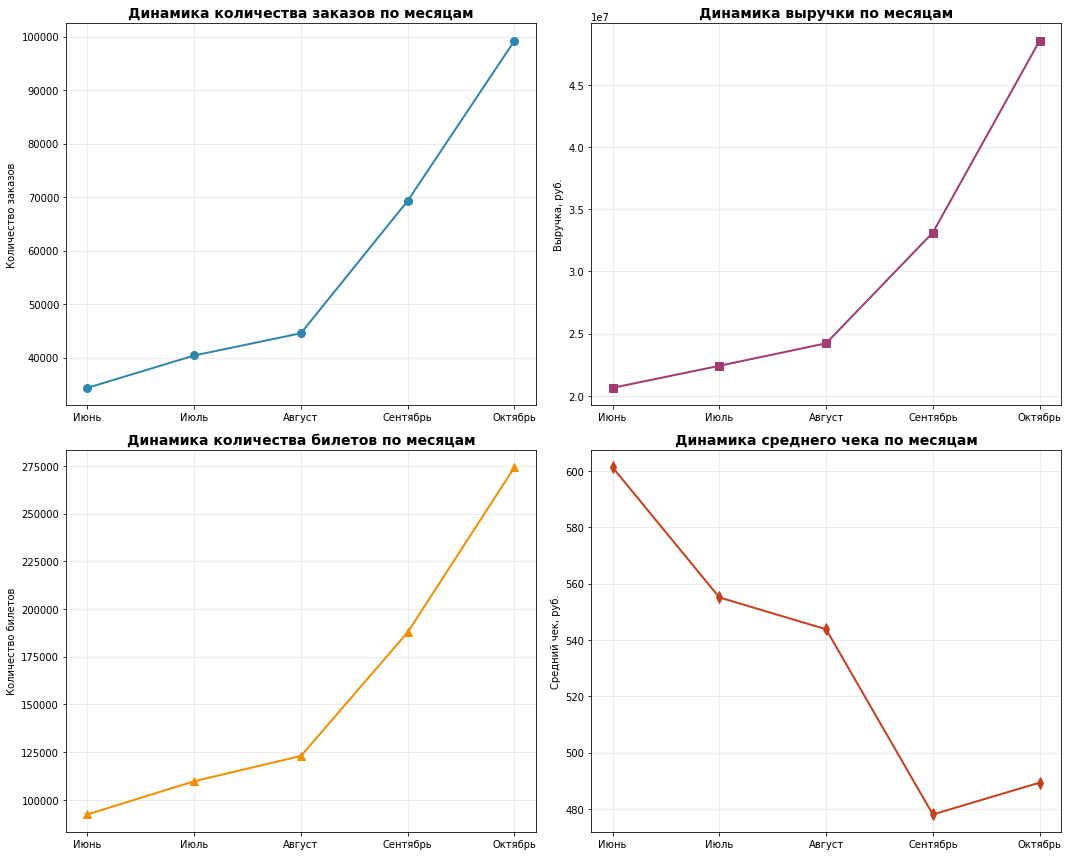

📈 РОСТ КОЛИЧЕСТВА ЗАКАЗОВ С ИЮНЯ ПО ОКТЯБРЬ: 189.0%


In [25]:
# Визуализация динамики заказов по месяцам
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Количество заказов по месяцам
axes[0, 0].plot(monthly_orders['month_name'], monthly_orders['total_orders'], 
                marker='o', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].set_title('Динамика количества заказов по месяцам', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Количество заказов')
axes[0, 0].grid(True, alpha=0.3)

# График 2: Выручка по месяцам
axes[0, 1].plot(monthly_orders['month_name'], monthly_orders['total_revenue'], 
                marker='s', linewidth=2, markersize=8, color='#A23B72')
axes[0, 1].set_title('Динамика выручки по месяцам', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Выручка, руб.')
axes[0, 1].grid(True, alpha=0.3)

# График 3: Количество билетов по месяцам
axes[1, 0].plot(monthly_orders['month_name'], monthly_orders['total_tickets'], 
                marker='^', linewidth=2, markersize=8, color='#F18F01')
axes[1, 0].set_title('Динамика количества билетов по месяцам', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Количество билетов')
axes[1, 0].grid(True, alpha=0.3)

# График 4: Средний чек по месяцам
monthly_orders['avg_revenue_per_order'] = monthly_orders['total_revenue'] / monthly_orders['total_orders']
axes[1, 1].plot(monthly_orders['month_name'], monthly_orders['avg_revenue_per_order'], 
                marker='d', linewidth=2, markersize=8, color='#C73E1D')
axes[1, 1].set_title('Динамика среднего чека по месяцам', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Средний чек, руб.')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ роста
jun_to_oct_growth = (monthly_orders.loc[monthly_orders['month'] == 10, 'total_orders'].values[0] / 
                     monthly_orders.loc[monthly_orders['month'] == 6, 'total_orders'].values[0] - 1) * 100

print(f"📈 РОСТ КОЛИЧЕСТВА ЗАКАЗОВ С ИЮНЯ ПО ОКТЯБРЬ: {jun_to_oct_growth:.1f}%")

In [26]:
# 3.1.2. Сравнение распределения заказов по сезонам (лето vs осень)
print("\n🌞❄️ СРАВНЕНИЕ РАСПРЕДЕЛЕНИЯ ЗАКАЗОВ: ЛЕТО VS ОСЕНЬ")
print("=" * 55)

# Создаем датафреймы для лета и осени
summer_df = final_df[final_df['season'] == 'лето']
autumn_df = final_df[final_df['season'] == 'осень']

print(f"Лето: {len(summer_df):,} заказов")
print(f"Осень: {len(autumn_df):,} заказов")


🌞❄️ СРАВНЕНИЕ РАСПРЕДЕЛЕНИЯ ЗАКАЗОВ: ЛЕТО VS ОСЕНЬ
Лето: 119,260 заказов
Осень: 168,522 заказов


In [27]:
# Функция для сравнения распределения по категориям
def compare_seasonal_distribution(summer_data, autumn_data, category_col, title):
    # Считаем распределение в процентах
    summer_dist = summer_data[category_col].value_counts(normalize=True) * 100
    autumn_dist = autumn_data[category_col].value_counts(normalize=True) * 100
    
    # Создаем датафрейм для визуализации
    dist_df = pd.DataFrame({
        'Лето': summer_dist,
        'Осень': autumn_dist
    }).fillna(0)
    
    # Сортируем по летнему распределению
    dist_df = dist_df.sort_values('Лето', ascending=False)
    
    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Столбчатая диаграмма
    dist_df.plot(kind='bar', ax=ax1, color=['#FFB347', '#7EC8E3'])
    ax1.set_title(f'Распределение заказов по {title}\n(доли в %)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Доля, %')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # Круговые диаграммы
    summer_dist.head(10).plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                             colors=plt.cm.Pastel1(np.linspace(0, 1, 10)))
    ax2.set_title(f'Лето - Топ-10 {title}', fontsize=12)
    ax2.set_ylabel('')
    
    plt.tight_layout()
    plt.show()
            
    return dist_df


🎭 РАСПРЕДЕЛЕНИЕ ПО ТИПАМ МЕРОПРИЯТИЙ


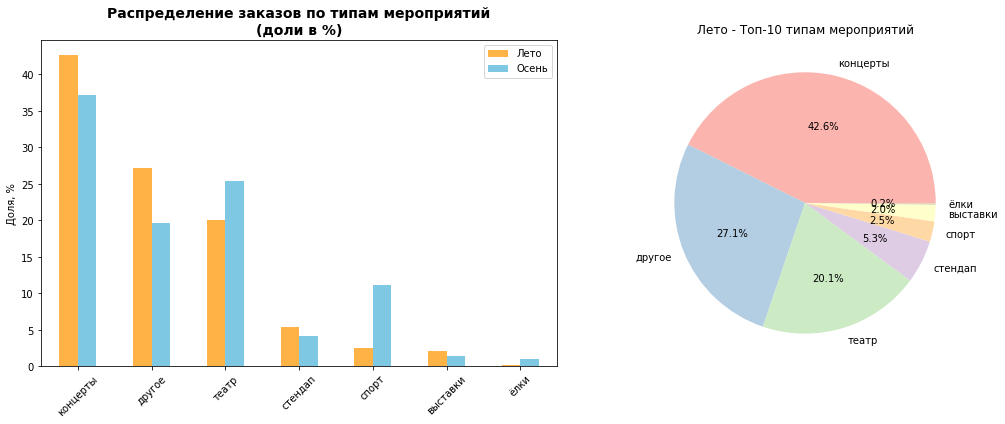

Изменение долей по типам мероприятий (осень vs лето):


,Лето,Осень,"Изменение, п.п.","Рост, %"
концерты,42.63,37.20,-5.43,-12.74
другое,27.14,19.68,-7.46,-27.49
театр,20.11,25.36,5.25,26.10
стендап,5.33,4.11,-1.22,-22.93
спорт,2.52,11.20,8.68,343.91
выставки,2.03,1.45,-0.58,-28.80
ёлки,0.23,1.00,0.77,337.09


In [28]:
# Анализ по типам мероприятий
print("\n🎭 РАСПРЕДЕЛЕНИЕ ПО ТИПАМ МЕРОПРИЯТИЙ")
event_type_dist = compare_seasonal_distribution(
    summer_df, autumn_df, 'event_type_main', 'типам мероприятий'
)

print("Изменение долей по типам мероприятий (осень vs лето):")
event_type_dist['Изменение, п.п.'] = event_type_dist['Осень'] - event_type_dist['Лето']
event_type_dist['Рост, %'] = (event_type_dist['Осень'] / event_type_dist['Лето'] - 1) * 100
display(event_type_dist.round(2))


📱💻 РАСПРЕДЕЛЕНИЕ ПО ТИПАМ УСТРОЙСТВ


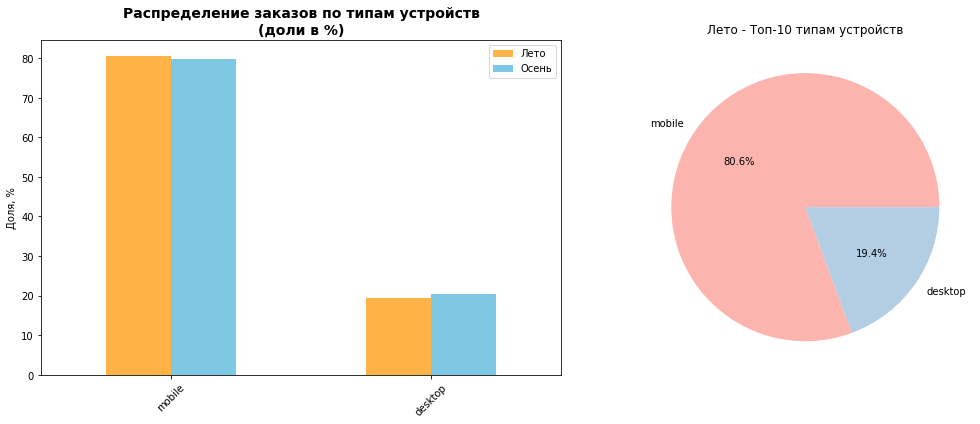

Изменение долей по типам устройств (осень vs лето):


,Лето,Осень,"Изменение, п.п.","Рост, %"
mobile,80.65,79.67,-0.98,-1.22
desktop,19.35,20.33,0.98,5.07


In [29]:
# Анализ по типам устройств
print("\n📱💻 РАСПРЕДЕЛЕНИЕ ПО ТИПАМ УСТРОЙСТВ")
device_dist = compare_seasonal_distribution(
    summer_df, autumn_df, 'device_type_canonical', 'типам устройств'
)

print("Изменение долей по типам устройств (осень vs лето):")
device_dist['Изменение, п.п.'] = device_dist['Осень'] - device_dist['Лето']
device_dist['Рост, %'] = (device_dist['Осень'] / device_dist['Лето'] - 1) * 100
display(device_dist.round(2))


🔞 РАСПРЕДЕЛЕНИЕ ПО ВОЗРАСТНЫМ РЕЙТИНГАМ


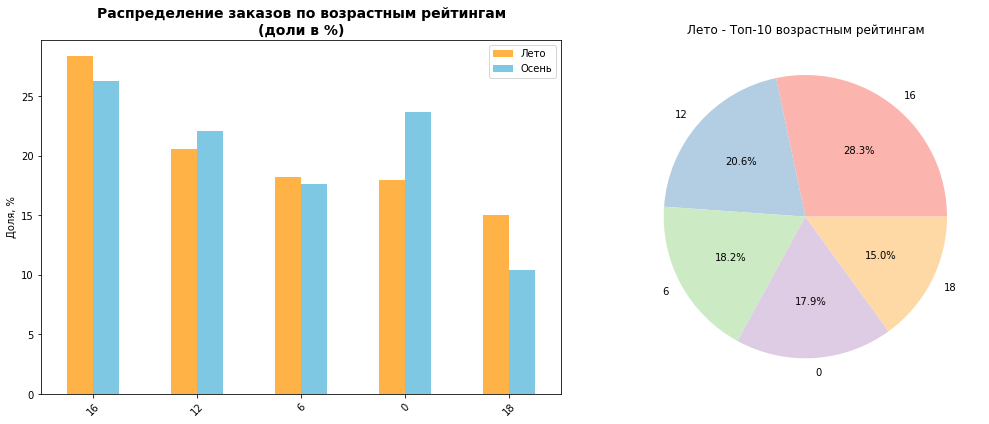

Изменение долей по возрастным рейтингам (осень vs лето):


,Лето,Осень,"Изменение, п.п.","Рост, %"
16,28.32,26.24,-2.08,-7.34
12,20.56,22.09,1.53,7.44
6,18.18,17.63,-0.55,-3.04
0,17.93,23.62,5.69,31.72
18,15.01,10.42,-4.59,-30.58


In [30]:
# Анализ по возрастным рейтингам
print("\n🔞 РАСПРЕДЕЛЕНИЕ ПО ВОЗРАСТНЫМ РЕЙТИНГАМ")
age_limit_dist = compare_seasonal_distribution(
    summer_df, autumn_df, 'age_limit', 'возрастным рейтингам'
)

print("Изменение долей по возрастным рейтингам (осень vs лето):")
age_limit_dist['Изменение, п.п.'] = age_limit_dist['Осень'] - age_limit_dist['Лето']
age_limit_dist['Рост, %'] = (age_limit_dist['Осень'] / age_limit_dist['Лето'] - 1) * 100
display(age_limit_dist.round(2))

In [31]:
# 3.1.3. Анализ изменения стоимости билетов по типам мероприятий
print("\n💰 ИЗМЕНЕНИЕ СТОИМОСТИ БИЛЕТОВ ПО ТИПАМ МЕРОПРИЯТИЙ")
print("=" * 65)

# Рассчитываем среднюю стоимость билета по типам мероприятий и сезонам
ticket_price_analysis = final_df.groupby(['event_type_main', 'season']).agg({
    'one_ticket_revenue_rub': 'mean',
    'order_id': 'count'
}).reset_index()

ticket_price_analysis = ticket_price_analysis.rename(columns={
    'one_ticket_revenue_rub': 'avg_ticket_price',
    'order_id': 'orders_count'
})

# Фильтруем только лето и осень, и мероприятия с достаточным количеством заказов
min_orders = 50  # минимальное количество заказов для анализа
filtered_analysis = ticket_price_analysis[
    (ticket_price_analysis['season'].isin(['лето', 'осень'])) & 
    (ticket_price_analysis['orders_count'] >= min_orders)
]

# Создаем сводную таблицу для сравнения
price_comparison = filtered_analysis.pivot_table(
    index='event_type_main',
    columns='season',
    values='avg_ticket_price'
).reset_index()

price_comparison = price_comparison.dropna()

# Рассчитываем изменение цены
price_comparison['price_change'] = price_comparison['осень'] - price_comparison['лето']
price_comparison['price_change_pct'] = (price_comparison['осень'] / price_comparison['лето'] - 1) * 100

print("Сравнение средней стоимости билета по типам мероприятий:")
display(price_comparison.round(2))


💰 ИЗМЕНЕНИЕ СТОИМОСТИ БИЛЕТОВ ПО ТИПАМ МЕРОПРИЯТИЙ
Сравнение средней стоимости билета по типам мероприятий:


season,event_type_main,лето,осень,price_change,price_change_pct
0,выставки,86.39,90.60,4.22,4.88
1,другое,77.40,76.07,-1.33,-1.71
2,концерты,304.73,268.10,-36.63,-12.02
3,спорт,50.74,49.98,-0.76,-1.51
4,стендап,218.52,231.12,12.61,5.77
5,театр,214.17,175.98,-38.19,-17.83
6,ёлки,271.44,229.56,-41.87,-15.43


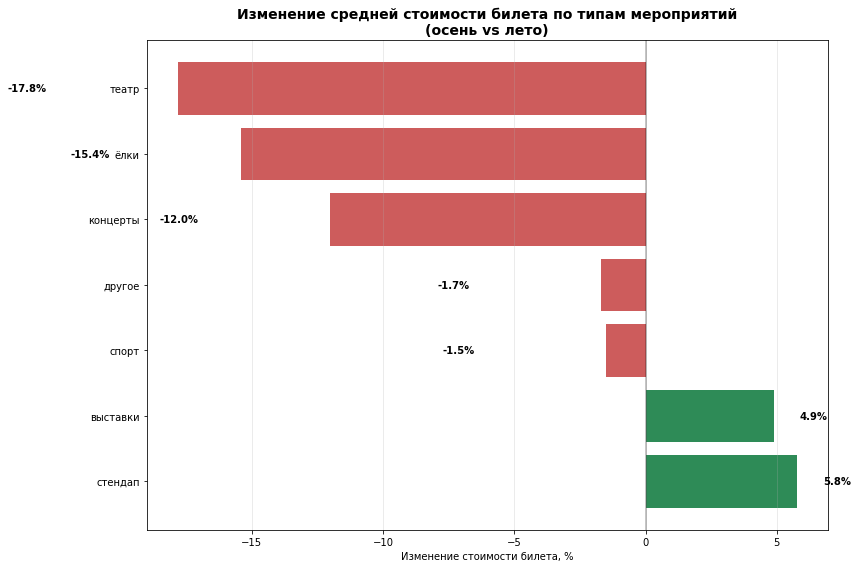

In [32]:
# Визуализация изменения стоимости билетов
plt.figure(figsize=(12, 8))

# Сортируем по изменению цены
price_comparison_sorted = price_comparison.sort_values('price_change_pct', ascending=False)

# Создаем график
bars = plt.barh(price_comparison_sorted['event_type_main'], 
                price_comparison_sorted['price_change_pct'],
                color=np.where(price_comparison_sorted['price_change_pct'] >= 0, '#2E8B57', '#CD5C5C'))

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Изменение стоимости билета, %')
plt.title('Изменение средней стоимости билета по типам мероприятий\n(осень vs лето)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars, price_comparison_sorted['price_change_pct']):
    plt.text(bar.get_width() + (1 if value >= 0 else -5), 
             bar.get_y() + bar.get_height()/2, 
             f'{value:.1f}%', 
             ha='left' if value >= 0 else 'right', 
             va='center',
             fontweight='bold')

plt.tight_layout()
plt.show()

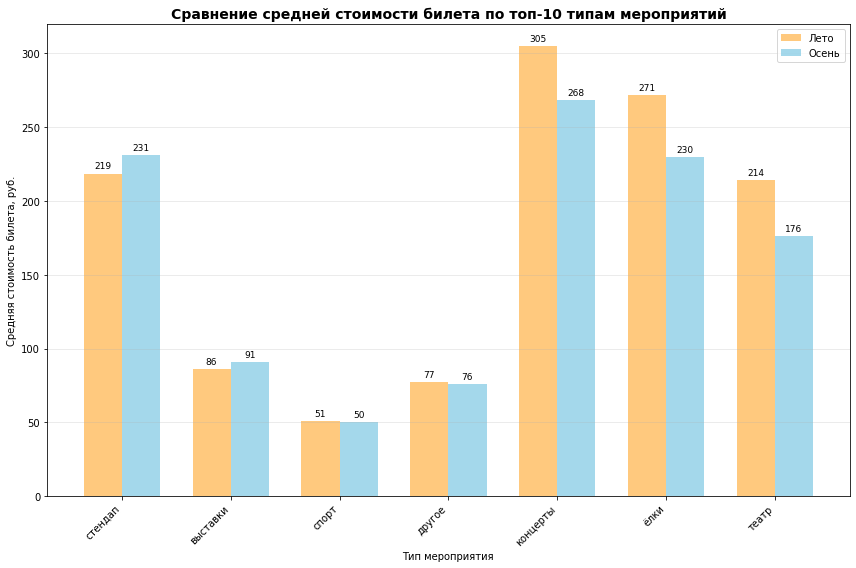

In [33]:
# Детальная визуализация по топ-10 типам мероприятий
top_events = price_comparison_sorted.head(10)

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top_events))
width = 0.35

bars1 = ax.bar(x - width/2, top_events['лето'], width, label='Лето', alpha=0.7, color='#FFB347')
bars2 = ax.bar(x + width/2, top_events['осень'], width, label='Осень', alpha=0.7, color='#7EC8E3')

ax.set_xlabel('Тип мероприятия')
ax.set_ylabel('Средняя стоимость билета, руб.')
ax.set_title('Сравнение средней стоимости билета по топ-10 типам мероприятий', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_events['event_type_main'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=9)

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.show()

📋 ВЫВОДЫ ПО АНАЛИЗУ СЕЗОННЫХ ИЗМЕНЕНИЙ
==================================================
🔍 ОСНОВНЫЕ НАБЛЮДЕНИЯ:

1. 📈 ДИНАМИКА ЗАКАЗОВ:
- Общий рост с июня по октябрь: 189.0%
- Летний период: 119,260 заказов
- Осенний период: 168,522 заказов

2. 🎭 ИЗМЕНЕНИЯ В ТИПАХ МЕРОПРИЯТИЙ:

    а) Наибольший рост популярности:
     - спорт: +8.7 п.п. (343.9%)
     - ёлки: +0.8 п.п. (337.1%)
     - театр: +5.2 п.п. (26.1%)
     
   б) Наибольшее снижение популярности:
     - выставки: -0.6 п.п. (-28.8%)
     - другое: -7.5 п.п. (-27.5%)
     - стендап: -1.2 п.п. (-22.9%)
     

3. 📱💻 ИЗМЕНЕНИЯ В ТИПАХ УСТРОЙСТВ:
- mobile: ↓ снижение на 1.0 п.п.
- desktop: ↑ рост на 1.0 п.п.

4. 🔞 ИЗМЕНЕНИЯ В ВОЗРАСТНЫХ РЕЙТИНГАХ:
- 0: +5.7 п.п.
- 12: +1.5 п.п.
- 6: +-0.6 п.п.

5. 💰 ИЗМЕНЕНИЯ В СТОИМОСТИ БИЛЕТОВ:
  
   - Наибольший рост стоимости:
     - стендап: +5.8%
     - выставки: +4.9%
     - спорт: +-1.5% 
   - Наибольшее снижение стоимости:
     - театр: -17.8%
     - ёлки: -15.4%
     - концерты: -12.0%

🎯 КЛЮЧЕВЫЕ ИНСАЙТЫ:
   - Подтверждена сезонность спроса с ростом осенью
   - Изменились предпочтения по типам мероприятий
   - Наблюдается сдвиг в использовании типов устройств
   - Стоимость билетов изменилась неравномерно по разным категориям

## 3.2. Осенняя активность пользователей

In [34]:
# Фильтруем данные только за осенние месяцы (сентябрь и октябрь)
autumn_data = final_df[final_df['season'] == 'осень'].copy()
print(f"Данные за осень 2024: {len(autumn_data):,} заказов")
print(f"Период: с {autumn_data['created_dt_msk'].min().date()} по {autumn_data['created_dt_msk'].max().date()}")

Данные за осень 2024: 168,522 заказов
Период: с 2024-09-01 по 2024-10-31


In [35]:
# 3.2.1. Создаем сводную таблицу по дням
print("\n📊 СОЗДАНИЕ СВОДНОЙ ТАБЛИЦЫ ПО ДНЯМ")
print("=" * 45)

daily_metrics = autumn_data.groupby(autumn_data['created_dt_msk'].dt.date).agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'revenue_rub': 'sum',
    'tickets_count': 'sum',
    'one_ticket_revenue_rub': 'mean'
}).reset_index()

daily_metrics = daily_metrics.rename(columns={
    'created_dt_msk': 'date',
    'order_id': 'total_orders',
    'user_id': 'dau',
    'revenue_rub': 'daily_revenue',
    'tickets_count': 'total_tickets',
    'one_ticket_revenue_rub': 'avg_ticket_price'
})

# Рассчитываем дополнительные метрики
daily_metrics['orders_per_user'] = daily_metrics['total_orders'] / daily_metrics['dau']
daily_metrics['weekday'] = pd.to_datetime(daily_metrics['date']).dt.day_name()

# Добавляем русские названия дней недели для визуализации
weekday_translation = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник', 
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}
daily_metrics['weekday_ru'] = daily_metrics['weekday'].map(weekday_translation)

print("Ежедневные метрики за осень:")
display(daily_metrics.head(10))


📊 СОЗДАНИЕ СВОДНОЙ ТАБЛИЦЫ ПО ДНЯМ
Ежедневные метрики за осень:


,date,total_orders,dau,daily_revenue,total_tickets,avg_ticket_price,orders_per_user,weekday,weekday_ru
0,2024-09-01,1327,564,7.262059e+05,3718,200.168708,2.352837,Sunday,Воскресенье
1,2024-09-02,1380,574,7.035384e+05,3704,189.464639,2.404181,Monday,Понедельник
2,2024-09-03,5111,778,1.151204e+06,15290,80.130097,6.569409,Tuesday,Вторник
3,2024-09-04,1772,684,8.557010e+05,4791,177.714537,2.590643,Wednesday,Среда
4,2024-09-05,1940,739,9.866274e+05,5177,189.763046,2.625169,Thursday,Четверг
5,2024-09-06,2123,864,1.008912e+06,5765,174.865064,2.457176,Friday,Пятница
6,2024-09-07,1957,794,1.019097e+06,5368,190.210367,2.464736,Saturday,Суббота
7,2024-09-08,1713,717,8.355298e+05,4549,181.973169,2.389121,Sunday,Воскресенье
8,2024-09-09,2092,779,8.845035e+05,5756,159.432396,2.685494,Monday,Понедельник
9,2024-09-10,2019,762,9.780787e+05,5349,183.193523,2.649606,Tuesday,Вторник



📈 ДИНАМИКА ОСЕННЕЙ АКТИВНОСТИ ПО ДНЯМ


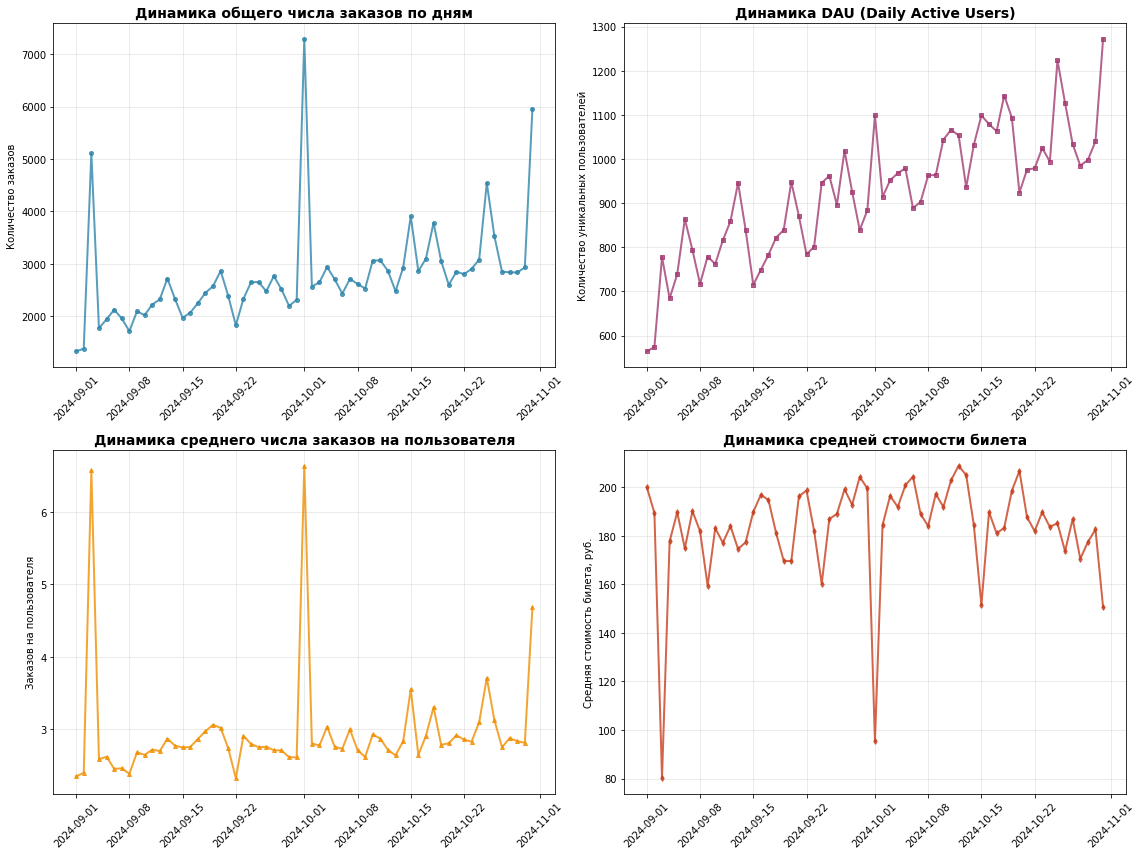

In [36]:
# 3.2.2. Визуализация динамики по дням
print("\n📈 ДИНАМИКА ОСЕННЕЙ АКТИВНОСТИ ПО ДНЯМ")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Общее число заказов
axes[0, 0].plot(daily_metrics['date'], daily_metrics['total_orders'], 
                marker='o', linewidth=2, markersize=4, color='#2E86AB', alpha=0.8)
axes[0, 0].set_title('Динамика общего числа заказов по дням', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Количество заказов')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# График 2: DAU (Daily Active Users)
axes[0, 1].plot(daily_metrics['date'], daily_metrics['dau'], 
                marker='s', linewidth=2, markersize=4, color='#A23B72', alpha=0.8)
axes[0, 1].set_title('Динамика DAU (Daily Active Users)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Количество уникальных пользователей')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# График 3: Среднее число заказов на пользователя
axes[1, 0].plot(daily_metrics['date'], daily_metrics['orders_per_user'], 
                marker='^', linewidth=2, markersize=4, color='#F18F01', alpha=0.8)
axes[1, 0].set_title('Динамика среднего числа заказов на пользователя', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Заказов на пользователя')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# График 4: Средняя стоимость одного билета
axes[1, 1].plot(daily_metrics['date'], daily_metrics['avg_ticket_price'], 
                marker='d', linewidth=2, markersize=4, color='#C73E1D', alpha=0.8)
axes[1, 1].set_title('Динамика средней стоимости билета', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Средняя стоимость билета, руб.')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


📅 АНАЛИЗ НЕДЕЛЬНОЙ ЦИКЛИЧНОСТИ
Средние показатели по дням недели:


,weekday_ru,is_weekend,total_orders,dau,orders_per_user,avg_ticket_price,daily_revenue
2,Понедельник,False,2389.56,853.67,2.78,184.38,1192752.44
1,Вторник,False,3496.78,934.11,3.72,156.51,1349148.53
4,Среда,False,2541.33,922.89,2.75,185.25,1276197.11
6,Четверг,False,3017.11,962.00,3.06,181.83,1444148.16
3,Пятница,False,3100.62,1022.38,3.00,185.21,1572222.26
5,Суббота,True,2666.38,960.50,2.76,192.35,1408395.91
0,Воскресенье,True,2153.67,822.44,2.60,197.59,1164525.95


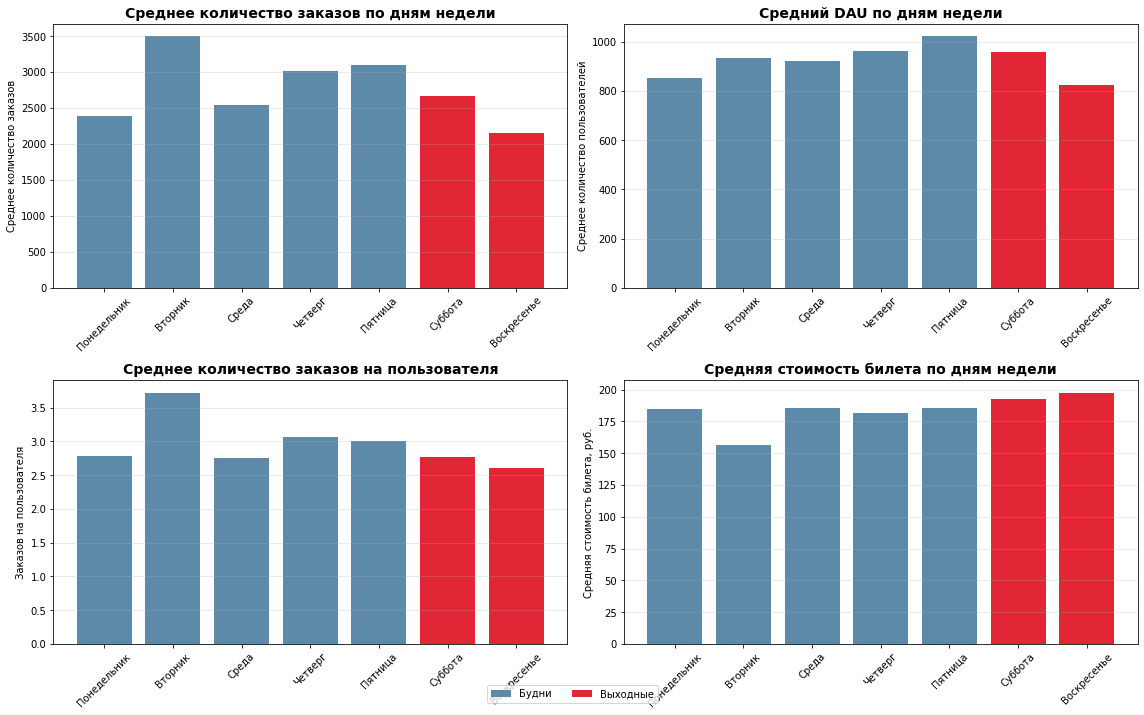

In [37]:
# 3.2.3. Анализ недельной цикличности
print("\n📅 АНАЛИЗ НЕДЕЛЬНОЙ ЦИКЛИЧНОСТИ")
print("=" * 40)

# Добавляем флаг выходного дня
daily_metrics['is_weekend'] = daily_metrics['weekday'].isin(['Saturday', 'Sunday'])

# Агрегируем по дням недели
weekday_analysis = daily_metrics.groupby(['weekday_ru', 'is_weekend']).agg({
    'total_orders': 'mean',
    'dau': 'mean',
    'orders_per_user': 'mean',
    'avg_ticket_price': 'mean',
    'daily_revenue': 'mean'
}).reset_index()

# Сортируем по порядку дней недели
weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
weekday_analysis['weekday_ru'] = pd.Categorical(weekday_analysis['weekday_ru'], categories=weekday_order, ordered=True)
weekday_analysis = weekday_analysis.sort_values('weekday_ru')

print("Средние показатели по дням недели:")
display(weekday_analysis.round(2))

# Визуализация недельной цикличности
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# График 1: Среднее количество заказов по дням недели
axes[0, 0].bar(weekday_analysis['weekday_ru'], weekday_analysis['total_orders'], 
               color=['#5D8AA8' if not x else '#E32636' for x in weekday_analysis['is_weekend']])
axes[0, 0].set_title('Среднее количество заказов по дням недели', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Среднее количество заказов')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# График 2: DAU по дням недели
axes[0, 1].bar(weekday_analysis['weekday_ru'], weekday_analysis['dau'], 
               color=['#5D8AA8' if not x else '#E32636' for x in weekday_analysis['is_weekend']])
axes[0, 1].set_title('Средний DAU по дням недели', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Среднее количество пользователей')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# График 3: Среднее количество заказов на пользователя
axes[1, 0].bar(weekday_analysis['weekday_ru'], weekday_analysis['orders_per_user'], 
               color=['#5D8AA8' if not x else '#E32636' for x in weekday_analysis['is_weekend']])
axes[1, 0].set_title('Среднее количество заказов на пользователя', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Заказов на пользователя')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# График 4: Средняя стоимость билета
axes[1, 1].bar(weekday_analysis['weekday_ru'], weekday_analysis['avg_ticket_price'], 
               color=['#5D8AA8' if not x else '#E32636' for x in weekday_analysis['is_weekend']])
axes[1, 1].set_title('Средняя стоимость билета по дням недели', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Средняя стоимость билета, руб.')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# Добавляем легенду
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#5D8AA8', label='Будни'),
    Patch(facecolor='#E32636', label='Выходные')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

In [38]:
# 3.2.4. Сравнение будней и выходных
print("\n⚖️ СРАВНЕНИЕ БУДНЕЙ И ВЫХОДНЫХ")
print("=" * 40)

weekend_comparison = daily_metrics.groupby('is_weekend').agg({
    'total_orders': ['mean', 'std'],
    'dau': ['mean', 'std'],
    'orders_per_user': ['mean', 'std'],
    'avg_ticket_price': ['mean', 'std'],
    'daily_revenue': ['mean', 'std'],
    'date': 'count'  # количество дней в каждой группе
}).round(2)

weekend_comparison.columns = ['_'.join(col).strip() for col in weekend_comparison.columns.values]
weekend_comparison = weekend_comparison.rename(columns={
    'total_orders_mean': 'avg_orders',
    'total_orders_std': 'std_orders',
    'dau_mean': 'avg_dau', 
    'dau_std': 'std_dau',
    'orders_per_user_mean': 'avg_orders_per_user',
    'orders_per_user_std': 'std_orders_per_user',
    'avg_ticket_price_mean': 'avg_ticket_price',
    'avg_ticket_price_std': 'std_ticket_price',
    'daily_revenue_mean': 'avg_daily_revenue',
    'daily_revenue_std': 'std_daily_revenue',
    'date_count': 'days_count'
})

weekend_comparison.index = ['Будни', 'Выходные']

print("Сравнительная таблица будней и выходных:")
display(weekend_comparison)

# Рассчитываем разницу в процентах
weekdays_avg = weekend_comparison.loc['Будни']
weekends_avg = weekend_comparison.loc['Выходные']

difference_pct = ((weekends_avg - weekdays_avg) / weekdays_avg * 100).round(1)

print("\n📊 РАЗНИЦА ВЫХОДНЫХ ОТНОСИТЕЛЬНО БУДНЕЙ (%):")
difference_df = pd.DataFrame({
    'Показатель': ['Средние заказы', 'DAU', 'Заказов на пользователя', 'Стоимость билета', 'Дневная выручка'],
    'Разница, %': [
        difference_pct['avg_orders'],
        difference_pct['avg_dau'], 
        difference_pct['avg_orders_per_user'],
        difference_pct['avg_ticket_price'],
        difference_pct['avg_daily_revenue']
    ]
})
display(difference_df)


⚖️ СРАВНЕНИЕ БУДНЕЙ И ВЫХОДНЫХ
Сравнительная таблица будней и выходных:


,avg_orders,std_orders,avg_dau,std_dau,avg_orders_per_user,std_orders_per_user,avg_ticket_price,std_ticket_price,avg_daily_revenue,std_daily_revenue,days_count
Будни,2904.73,1060.66,937.11,140.82,3.06,0.86,178.49,23.31,1362227.14,331919.41,44
Выходные,2394.94,538.55,887.41,148.04,2.68,0.20,195.12,10.46,1279288.29,291533.37,17



📊 РАЗНИЦА ВЫХОДНЫХ ОТНОСИТЕЛЬНО БУДНЕЙ (%):


,Показатель,"Разница, %"
0,Средние заказы,-17.6
1,DAU,-5.3
2,Заказов на пользователя,-12.4
3,Стоимость билета,9.3
4,Дневная выручка,-6.1


📋 ВЫВОДЫ ПО ОСЕННЕЙ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ
=======================================================
🔍 ОСНОВНЫЕ НАБЛЮДЕНИЯ:

1. 📈 ОБЩАЯ ДИНАМИКА ЗА ОСЕНЬ:
   - Всего заказов за осень: 168,522
   - Уникальных пользователей: 15,803
   - Среднедневное количество заказов: 2763
   - Среднедневной DAU: 923


2. 📅 НЕДЕЛЬНАЯ ЦИКЛИЧНОСТЬ:
   - Самый активный день: Вторник (3497 заказов)
   - Наименее активный день: Воскресенье (2154 заказов)


3. ⚖️ СРАВНЕНИЕ БУДНИ/ВЫХОДНЫЕ:
   - Рост заказов в выходные: -17.6%
   - Рост DAU в выходные: -5.3%
   - Рост выручки в выходные: -6.1%


4. 🧠 ПОВЕДЕНЧЕСКИЕ ИНСАЙТЫ:
   - Волатильность заказов в будни: 1060.7
   - Волатильность заказов в выходные: 538.5
   - Разница в стоимости билетов (выходные - будни): +16.6 руб.

🎯 КЛЮЧЕВЫЕ ВЫВОДЫ:
   - Подтверждена ярко выраженная недельная цикличность
   - Выходные демонстрируют значительный рост активности
   - Наблюдается стабильный паттерн пользовательского поведения
   - Динамика стоимости билетов имеет свои особенности

##  3.3. Популярные события и партнёры

In [39]:
# 3.3.1. Анализ популярности по регионам
print("🌍 АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПО РЕГИОНАМ")
print("=" * 45)

# Считаем метрики по регионам
region_analysis = final_df.groupby('region_name').agg({
    'event_id': 'nunique',  # уникальные мероприятия
    'order_id': 'count',    # общее число заказов
    'revenue_rub': 'sum',   # суммарная выручка
    'user_id': 'nunique'    # уникальные пользователи
}).reset_index()

region_analysis = region_analysis.rename(columns={
    'event_id': 'unique_events',
    'order_id': 'total_orders',
    'user_id': 'unique_users'
})

# Рассчитываем доли
total_events = region_analysis['unique_events'].sum()
total_orders_all = region_analysis['total_orders'].sum()
total_revenue_all = region_analysis['revenue_rub'].sum()

region_analysis['events_share'] = (region_analysis['unique_events'] / total_events * 100).round(2)
region_analysis['orders_share'] = (region_analysis['total_orders'] / total_orders_all * 100).round(2)
region_analysis['revenue_share'] = (region_analysis['revenue_rub'] / total_revenue_all * 100).round(2)

# Сортируем по количеству мероприятий
region_analysis = region_analysis.sort_values('unique_events', ascending=False)

print("Топ-10 регионов по количеству мероприятий:")
display(region_analysis.head(10))

🌍 АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПО РЕГИОНАМ
Топ-10 регионов по количеству мероприятий:


,region_name,unique_events,total_orders,revenue_rub,unique_users,events_share,orders_share,revenue_share
23,Каменевский регион,5933,89649,5.589575e+07,10550,26.55,31.18,37.52
60,Североярская область,3797,43627,2.197790e+07,6683,16.99,15.17,14.75
77,Широковская область,1232,16164,8.627051e+06,3249,5.51,5.62,5.79
57,Светополянский округ,1075,7502,3.038712e+06,1659,4.81,2.61,2.04
52,Речиновская область,702,6266,2.630063e+06,1528,3.14,2.18,1.77
74,Травяная область,683,5036,1.787821e+06,1381,3.06,1.75,1.20
11,Горицветская область,551,5153,1.697500e+06,962,2.47,1.79,1.14
61,Серебринская область,541,5586,2.106600e+06,1317,2.42,1.94,1.41
78,Яблоневская область,535,6124,3.505536e+06,1422,2.39,2.13,2.35
69,Тепляковская область,528,4385,1.382440e+06,1046,2.36,1.52,0.93


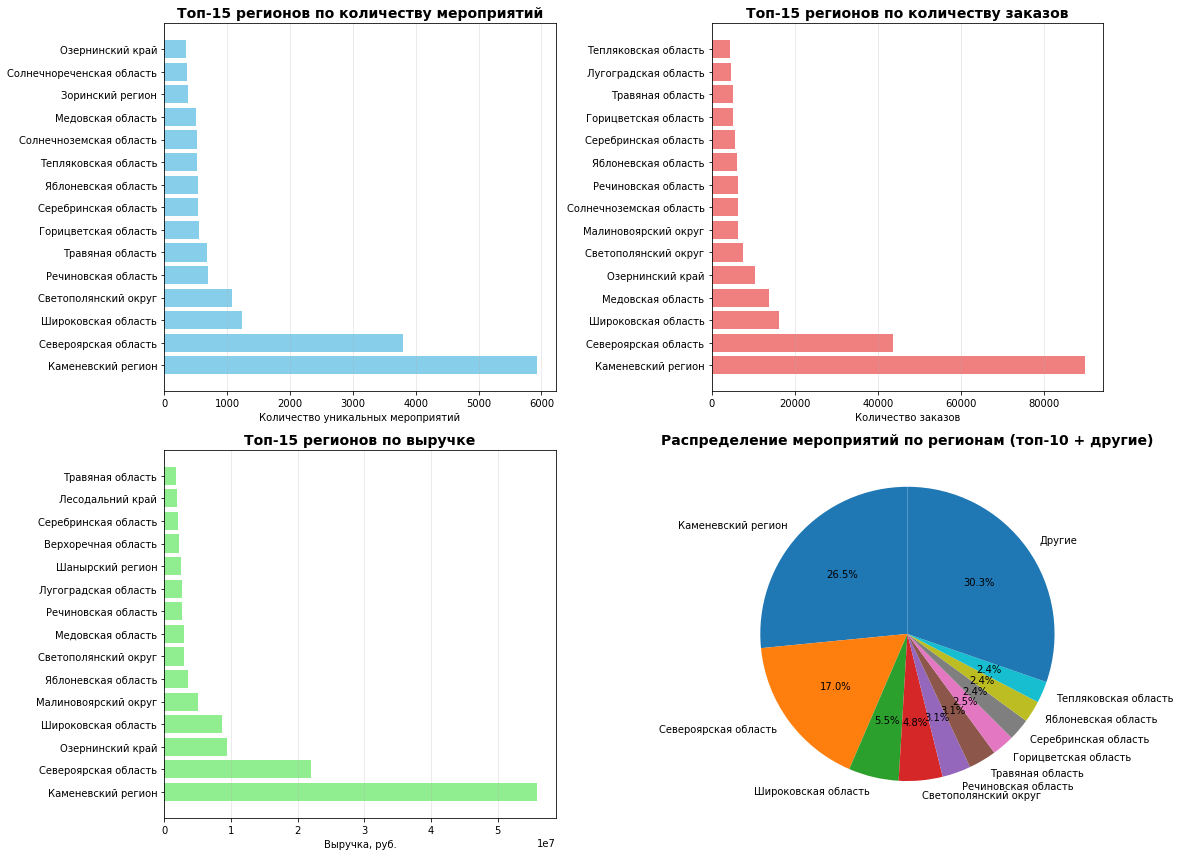

In [40]:
# Визуализация распределения по регионам
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Топ-15 регионов по количеству мероприятий
top_regions_events = region_analysis.head(15)
axes[0, 0].barh(top_regions_events['region_name'], top_regions_events['unique_events'], 
                color='skyblue')
axes[0, 0].set_title('Топ-15 регионов по количеству мероприятий', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Количество уникальных мероприятий')
axes[0, 0].grid(axis='x', alpha=0.3)

# Топ-15 регионов по количеству заказов
top_regions_orders = region_analysis.nlargest(15, 'total_orders')
axes[0, 1].barh(top_regions_orders['region_name'], top_regions_orders['total_orders'], 
                color='lightcoral')
axes[0, 1].set_title('Топ-15 регионов по количеству заказов', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Количество заказов')
axes[0, 1].grid(axis='x', alpha=0.3)

# Топ-15 регионов по выручке
top_regions_revenue = region_analysis.nlargest(15, 'revenue_rub')
axes[1, 0].barh(top_regions_revenue['region_name'], top_regions_revenue['revenue_rub'], 
                color='lightgreen')
axes[1, 0].set_title('Топ-15 регионов по выручке', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Выручка, руб.')
axes[1, 0].grid(axis='x', alpha=0.3)

# Доли регионов в общем количестве мероприятий (круговая диаграмма для топ-10)
top_10_events = region_analysis.head(10)
other_events = region_analysis[10:]['unique_events'].sum()
events_for_pie = pd.concat([
    top_10_events[['region_name', 'unique_events']],
    pd.DataFrame({'region_name': ['Другие'], 'unique_events': [other_events]})
])

axes[1, 1].pie(events_for_pie['unique_events'], labels=events_for_pie['region_name'], 
               autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Распределение мероприятий по регионам (топ-10 + другие)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [41]:
# Анализ концентрации по регионам
print("\n📊 КОНЦЕНТРАЦИЯ ПО РЕГИОНАМ")
print("=" * 35)

top_5_events_share = region_analysis.head(5)['events_share'].sum()
top_5_orders_share = region_analysis.head(5)['orders_share'].sum()
top_5_revenue_share = region_analysis.head(5)['revenue_share'].sum()

print(f"Доля топ-5 регионов в общем количестве мероприятий: {top_5_events_share:.1f}%")
print(f"Доля топ-5 регионов в общем количестве заказов: {top_5_orders_share:.1f}%")
print(f"Доля топ-5 регионов в общей выручке: {top_5_revenue_share:.1f}%")

# Показатель разнообразия (количество регионов, покрывающих 80% мероприятий)
cumulative_share = region_analysis['events_share'].cumsum()
regions_80_percent = (cumulative_share <= 80).sum()
print(f"Количество регионов, покрывающих 80% мероприятий: {regions_80_percent}")


📊 КОНЦЕНТРАЦИЯ ПО РЕГИОНАМ
Доля топ-5 регионов в общем количестве мероприятий: 57.0%
Доля топ-5 регионов в общем количестве заказов: 56.8%
Доля топ-5 регионов в общей выручке: 61.9%
Количество регионов, покрывающих 80% мероприятий: 15



🤝 АНАЛИЗ БИЛЕТНЫХ ПАРТНЁРОВ
Анализ билетных партнеров:


,service_name,unique_events,total_orders,revenue_rub,unique_users,total_tickets,events_share,orders_share,revenue_share,avg_order_value,avg_tickets_per_order
3,Билеты без проблем,4249,62902,2.413474e+07,8814,171417,17.42,21.86,16.20,383.69,2.73
24,Мой билет,1299,34421,2.201855e+07,6229,92735,5.32,11.96,14.78,639.68,2.69
25,Облачко,2335,26402,1.858861e+07,5341,67778,9.57,9.17,12.48,704.06,2.57
21,Лови билет!,4869,40802,1.667009e+07,6346,112695,19.96,14.18,11.19,408.56,2.76
8,Весь в билетах,855,16410,1.649467e+07,3651,46295,3.50,5.70,11.07,1005.16,2.82
5,Билеты в руки,3536,40300,1.319486e+07,5721,112744,14.49,14.00,8.86,327.42,2.80
19,Край билетов,252,6108,6.403469e+06,1701,16978,1.03,2.12,4.30,1048.37,2.78
26,Прачечная,1026,10222,4.746811e+06,2094,28397,4.21,3.55,3.19,464.37,2.78
13,Дом культуры,272,4412,4.358656e+06,1333,12454,1.11,1.53,2.93,987.91,2.82
35,Яблоко,714,5004,3.868337e+06,1422,14218,2.93,1.74,2.60,773.05,2.84


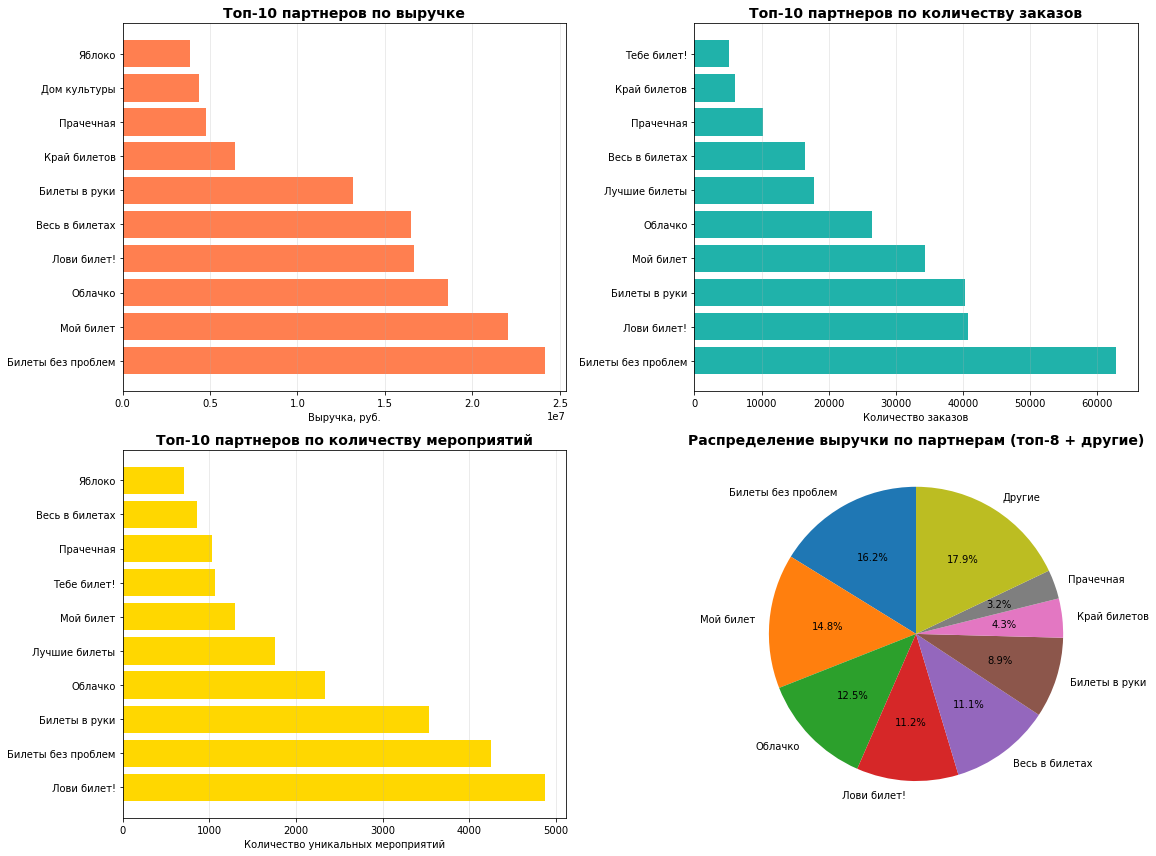


📊 КОНЦЕНТРАЦИЯ ПО ПАРТНЁРАМ
Доля топ-3 партнеров в количестве мероприятий: 32.3%
Доля топ-3 партнеров в количестве заказов: 43.0%
Доля топ-3 партнеров в выручке: 43.5%

📈 ЭФФЕКТИВНОСТЬ ПАРТНЁРОВ:
Средние показатели по всем партнерам:
  - Средний чек: 617.01 руб.
  - Среднее количество билетов в заказе: 2.85

Партнеры с самым высоким средним чеком (от 100+ заказов):
  - Росбилет: 1302.57 руб.
  - Край билетов: 1048.37 руб.
  - Быстрый кассир: 1046.68 руб.

Партнеры с наибольшим количеством билетов в заказе (от 100+ заказов):
  - КарандашРУ: 3.08 билетов/заказ
  - Радио ticket: 2.98 билетов/заказ
  - Городской дом культуры: 2.95 билетов/заказ


In [42]:
# 3.3.2. Анализ билетных партнёров
print("\n🤝 АНАЛИЗ БИЛЕТНЫХ ПАРТНЁРОВ")
print("=" * 40)

# Считаем метрики по партнерам
partner_analysis = final_df.groupby('service_name').agg({
    'event_id': 'nunique',    # уникальные мероприятия
    'order_id': 'count',      # обработанные заказы
    'revenue_rub': 'sum',     # суммарная выручка
    'user_id': 'nunique',     # уникальные пользователи
    'tickets_count': 'sum'    # общее количество билетов
}).reset_index()

partner_analysis = partner_analysis.rename(columns={
    'event_id': 'unique_events',
    'order_id': 'total_orders',
    'user_id': 'unique_users',
    'tickets_count': 'total_tickets'
})

# Рассчитываем доли и средние показатели
total_partners_events = partner_analysis['unique_events'].sum()
total_partners_orders = partner_analysis['total_orders'].sum()
total_partners_revenue = partner_analysis['revenue_rub'].sum()

partner_analysis['events_share'] = (partner_analysis['unique_events'] / total_partners_events * 100).round(2)
partner_analysis['orders_share'] = (partner_analysis['total_orders'] / total_partners_orders * 100).round(2)
partner_analysis['revenue_share'] = (partner_analysis['revenue_rub'] / total_partners_revenue * 100).round(2)
partner_analysis['avg_order_value'] = (partner_analysis['revenue_rub'] / partner_analysis['total_orders']).round(2)
partner_analysis['avg_tickets_per_order'] = (partner_analysis['total_tickets'] / partner_analysis['total_orders']).round(2)

# Сортируем по выручке
partner_analysis = partner_analysis.sort_values('revenue_rub', ascending=False)

print("Анализ билетных партнеров:")
display(partner_analysis.head(10))

# Визуализация анализа партнеров
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Топ-10 партнеров по выручке
top_partners_revenue = partner_analysis.head(10)
axes[0, 0].barh(top_partners_revenue['service_name'], top_partners_revenue['revenue_rub'], 
                color='coral')
axes[0, 0].set_title('Топ-10 партнеров по выручке', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Выручка, руб.')
axes[0, 0].grid(axis='x', alpha=0.3)

# Топ-10 партнеров по количеству заказов
top_partners_orders = partner_analysis.nlargest(10, 'total_orders')
axes[0, 1].barh(top_partners_orders['service_name'], top_partners_orders['total_orders'], 
                color='lightseagreen')
axes[0, 1].set_title('Топ-10 партнеров по количеству заказов', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Количество заказов')
axes[0, 1].grid(axis='x', alpha=0.3)

# Топ-10 партнеров по количеству мероприятий
top_partners_events = partner_analysis.nlargest(10, 'unique_events')
axes[1, 0].barh(top_partners_events['service_name'], top_partners_events['unique_events'], 
                color='gold')
axes[1, 0].set_title('Топ-10 партнеров по количеству мероприятий', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Количество уникальных мероприятий')
axes[1, 0].grid(axis='x', alpha=0.3)

# Доли партнеров в общей выручке (круговая диаграмма для топ-8)
top_8_revenue = partner_analysis.head(8)
other_revenue = partner_analysis[8:]['revenue_rub'].sum()
revenue_for_pie = pd.concat([
    top_8_revenue[['service_name', 'revenue_rub']],
    pd.DataFrame({'service_name': ['Другие'], 'revenue_rub': [other_revenue]})
])

axes[1, 1].pie(revenue_for_pie['revenue_rub'], labels=revenue_for_pie['service_name'], 
               autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Распределение выручки по партнерам (топ-8 + другие)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Анализ концентрации по партнерам
print("\n📊 КОНЦЕНТРАЦИЯ ПО ПАРТНЁРАМ")
print("=" * 35)

top_3_partners_events_share = partner_analysis.head(3)['events_share'].sum()
top_3_partners_orders_share = partner_analysis.head(3)['orders_share'].sum()
top_3_partners_revenue_share = partner_analysis.head(3)['revenue_share'].sum()

print(f"Доля топ-3 партнеров в количестве мероприятий: {top_3_partners_events_share:.1f}%")
print(f"Доля топ-3 партнеров в количестве заказов: {top_3_partners_orders_share:.1f}%")
print(f"Доля топ-3 партнеров в выручке: {top_3_partners_revenue_share:.1f}%")

# Анализ эффективности партнеров
print("\n📈 ЭФФЕКТИВНОСТЬ ПАРТНЁРОВ:")
print("Средние показатели по всем партнерам:")
print(f"  - Средний чек: {partner_analysis['avg_order_value'].mean():.2f} руб.")
print(f"  - Среднее количество билетов в заказе: {partner_analysis['avg_tickets_per_order'].mean():.2f}")

# Находим партнеров с самыми высокими средними показателями
top_avg_order = partner_analysis[partner_analysis['total_orders'] >= 100].nlargest(3, 'avg_order_value')
top_avg_tickets = partner_analysis[partner_analysis['total_orders'] >= 100].nlargest(3, 'avg_tickets_per_order')

print("\nПартнеры с самым высоким средним чеком (от 100+ заказов):")
for _, partner in top_avg_order.iterrows():
    print(f"  - {partner['service_name']}: {partner['avg_order_value']:.2f} руб.")

print("\nПартнеры с наибольшим количеством билетов в заказе (от 100+ заказов):")
for _, partner in top_avg_tickets.iterrows():
    print(f"  - {partner['service_name']}: {partner['avg_tickets_per_order']:.2f} билетов/заказ")

In [43]:
# 3.3.3. Анализ распределения данных между категориями
print("\n📋 АНАЛИЗ РАСПРЕДЕЛЕНИЯ ДАННЫХ МЕЖДУ КАТЕГОРИЯМИ")
print("=" * 55)

# Анализ концентрации - индекс Херфиндаля-Хиршмана для регионов и партнеров
def calculate_hhi(series):
    """Рассчитывает индекс Херфиндаля-Хиршмана для измерения концентрации"""
    shares = series / series.sum() * 100
    hhi = (shares ** 2).sum()
    return hhi

# HHI для регионов (по мероприятиям)
hhi_regions_events = calculate_hhi(region_analysis['unique_events'])
hhi_regions_orders = calculate_hhi(region_analysis['total_orders'])
hhi_regions_revenue = calculate_hhi(region_analysis['revenue_rub'])

# HHI для партнеров
hhi_partners_events = calculate_hhi(partner_analysis['unique_events'])
hhi_partners_orders = calculate_hhi(partner_analysis['total_orders'])
hhi_partners_revenue = calculate_hhi(partner_analysis['revenue_rub'])

print("📊 ИНДЕКС КОНЦЕНТРАЦИИ (HHI):")
print("   (1500+ - высокая концентрация, 1000-1500 - умеренная, <1000 - низкая)")
print(f"\nРегионы:")
print(f"  - По мероприятиям: {hhi_regions_events:.0f}")
print(f"  - По заказам: {hhi_regions_orders:.0f}")
print(f"  - По выручке: {hhi_regions_revenue:.0f}")

print(f"\nПартнеры:")
print(f"  - По мероприятиям: {hhi_partners_events:.0f}")
print(f"  - По заказам: {hhi_partners_orders:.0f}")
print(f"  - По выручке: {hhi_partners_revenue:.0f}")


📋 АНАЛИЗ РАСПРЕДЕЛЕНИЯ ДАННЫХ МЕЖДУ КАТЕГОРИЯМИ
📊 ИНДЕКС КОНЦЕНТРАЦИИ (HHI):
   (1500+ - высокая концентрация, 1000-1500 - умеренная, <1000 - низкая)

Регионы:
  - По мероприятиям: 1120
  - По заказам: 1323
  - По выручке: 1750

Партнеры:
  - По мероприятиям: 1152
  - По заказам: 1202
  - По выручке: 1022


📋 ВЫВОДЫ ПО ПОПУЛЯРНЫМ СОБЫТИЯМ И ПАРТНЁРАМ
============================================================
🔍 ОСНОВНЫЕ НАБЛЮДЕНИЯ:

1. 🌍 РЕГИОНАЛЬНОЕ РАСПРЕДЕЛЕНИЕ:
   - Регион-лидер по мероприятиям: Каменевский регион
     (5933 мероприятий, 26.55% от общего числа)
   - Регион-лидер по заказам: Каменевский регион
     (89649 заказов, 31.18% от общего числа)
   - Регион-лидер по выручке: Каменевский регион
     (55,895,749 руб., 37.52% от общей выручки)


2. 🤝 БИЛЕТНЫЕ ПАРТНЁРЫ:
   - Партнер-лидер по выручке: Билеты без проблем
     (24,134,742 руб., 16.2% от общей выручки)
   - Партнер-лидер по заказам: Билеты без проблем
     (62902 заказов, 21.86% от общего числа)
   - Партнер-лидер по мероприятиям: Лови билет!
     (4869 мероприятий, 19.96% от общего числа)


3. 📊 КОНЦЕНТРАЦИЯ РЫНКА:
   - Регионы: 15 регионов покрывают 80% мероприятий
   - Партнеры: топ-3 контролируют 43.5% выручки


4. 📈 ЭФФЕКТИВНОСТЬ ПАРТНЁРОВ:
   - Партнер с самым высоким средним чеком: Росбилет
     (1303 руб. за заказ)
   - Партнер с наибольшим количеством билетов в заказе: КарандашРУ
     (3.1 билетов в среднем)

🎯 КЛЮЧЕВЫЕ ИНСАЙТЫ:
   - Выявлены явные лидеры среди регионов и партнеров
   - Наблюдается умеренная концентрация в обоих сегментах
   - Разные партнеры демонстрируют разную бизнес-модель (ценовая vs объемная)
   - Региональное покрытие показывает определенную сбалансированность

## Шаг 4. Статистический анализ данных

In [44]:
# 4.1. Подготовка данных для статистического анализа
print("🔧 ПОДГОТОВКА ДАННЫХ ДЛЯ СТАТИСТИЧЕСКОГО АНАЛИЗА")
print("=" * 55)

# Используем только осенние данные
autumn_data = final_df[final_df['season'] == 'осень'].copy()

print(f"Данные за осень 2024: {len(autumn_data):,} заказов")
print(f"Уникальных пользователей: {autumn_data['user_id'].nunique():,}")
print(f"Распределение по устройствам:")
print(autumn_data['device_type_canonical'].value_counts())

# КРИТИЧЕСКОЕ ИСПРАВЛЕНИЕ: Проверка пользователей, использующих оба типа устройств
print("\n🔍 ПРОВЕРКА ПОЛЬЗОВАТЕЛЕЙ С РАЗНЫМИ ТИПАМИ УСТРОЙСТВ")
print("=" * 60)

# Определяем пользователей, которые используют оба типа устройств
users_by_device = autumn_data.groupby('user_id')['device_type_canonical'].nunique()
mixed_users = users_by_device[users_by_device > 1].index.tolist()

print(f"Пользователей, использующих оба типа устройств: {len(mixed_users)}")
print(f"Это составляет {len(mixed_users)/autumn_data['user_id'].nunique()*100:.2f}% от всех пользователей")

if len(mixed_users) > 0:
    print("\nПримеры пользователей с разными устройствами:")
    mixed_users_sample = autumn_data[autumn_data['user_id'].isin(mixed_users)].head(10)
    display(mixed_users_sample[['user_id', 'device_type_canonical', 'order_id', 'created_dt_msk']])
    
    # УДАЛЯЕМ этих пользователей для обеспечения независимости выборок
    initial_user_count = autumn_data['user_id'].nunique()
    autumn_data_clean = autumn_data[~autumn_data['user_id'].isin(mixed_users)]
    removed_user_count = initial_user_count - autumn_data_clean['user_id'].nunique()
    
    print(f"\n✅ Удалено пользователей с обоими типами устройств: {removed_user_count}")
    print(f"Осталось пользователей для анализа: {autumn_data_clean['user_id'].nunique()}")
else:
    autumn_data_clean = autumn_data.copy()
    print("✅ Нет пользователей с обоими типами устройств - данные чистые")

🔧 ПОДГОТОВКА ДАННЫХ ДЛЯ СТАТИСТИЧЕСКОГО АНАЛИЗА
Данные за осень 2024: 168,522 заказов
Уникальных пользователей: 15,803
Распределение по устройствам:
mobile     134261
desktop     34261
Name: device_type_canonical, dtype: int64

🔍 ПРОВЕРКА ПОЛЬЗОВАТЕЛЕЙ С РАЗНЫМИ ТИПАМИ УСТРОЙСТВ
Пользователей, использующих оба типа устройств: 3249
Это составляет 20.56% от всех пользователей

Примеры пользователей с разными устройствами:


,user_id,device_type_canonical,order_id,created_dt_msk
34,0028d17a676f8c8,desktop,5896542,2024-09-07
35,0028d17a676f8c8,mobile,7613748,2024-10-06
38,002b75ca606ba46,mobile,3020960,2024-10-02
39,002b75ca606ba46,desktop,3020989,2024-10-02
40,002b75ca606ba46,desktop,4723086,2024-10-16
41,002b75ca606ba46,desktop,4723115,2024-10-16
53,002ec276eee9b0b,desktop,8408087,2024-09-07
54,002ec276eee9b0b,mobile,852862,2024-09-21
55,002ec276eee9b0b,mobile,852717,2024-09-21
56,002ec276eee9b0b,mobile,852746,2024-09-21



✅ Удалено пользователей с обоими типами устройств: 3249
Осталось пользователей для анализа: 12554



📈 ГИПОТЕЗА 1: КОЛИЧЕСТВО ЗАКАЗОВ НА ПОЛЬЗОВАТЕЛЯ
📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА (на независимых выборках):
Мобильные устройства (n=10936):
count    10936.000000
mean         2.858998
std          4.097492
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        123.000000
Name: orders_count, dtype: float64

Стационарные устройства (n=1618):
count    1618.000000
mean        1.975896
std         3.079453
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        56.000000
Name: orders_count, dtype: float64

🔒 ПРОВЕРКА НЕЗАВИСИМОСТИ ВЫБОРОК:
Уникальных мобильных пользователей: 10936
Уникальных десктопных пользователей: 1618
Пересекающихся пользователей: 0
✅ Выборки независимы - можно проводить статистические тесты


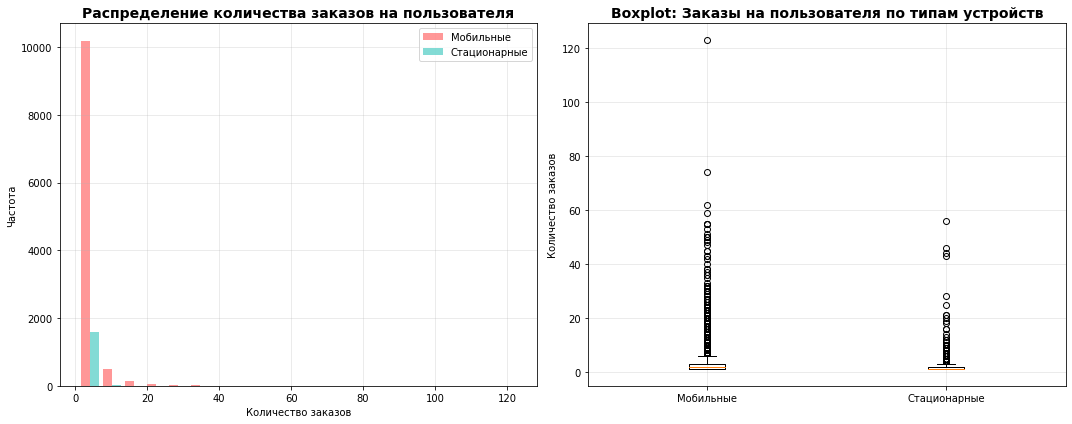


📏 ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ:
Тест Шапиро-Уилка (нормальность):
Мобильные устройства: W=0.4534, p-value=0.0000
Стационарные устройства: W=0.2984, p-value=0.0000
❌ Распределения не нормальны - используем непараметрический тест


In [45]:
# 4.2. Анализ данных для гипотезы 1: количество заказов на пользователя
print("\n📈 ГИПОТЕЗА 1: КОЛИЧЕСТВО ЗАКАЗОВ НА ПОЛЬЗОВАТЕЛЯ")
print("=" * 60)

# Считаем количество заказов на пользователя по типам устройств (на очищенных данных)
orders_per_user = autumn_data_clean.groupby(['user_id', 'device_type_canonical']).agg({
    'order_id': 'count'
}).reset_index()

orders_per_user = orders_per_user.rename(columns={'order_id': 'orders_count'})

# Разделяем на две группы (теперь независимые)
mobile_orders = orders_per_user[orders_per_user['device_type_canonical'] == 'mobile']['orders_count']
desktop_orders = orders_per_user[orders_per_user['device_type_canonical'] == 'desktop']['orders_count']

print("📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА (на независимых выборках):")
print(f"Мобильные устройства (n={len(mobile_orders)}):")
print(mobile_orders.describe())
print(f"\nСтационарные устройства (n={len(desktop_orders)}):")
print(desktop_orders.describe())

# Дополнительная проверка: убедимся, что пользователи не пересекаются
mobile_users = set(orders_per_user[orders_per_user['device_type_canonical'] == 'mobile']['user_id'])
desktop_users = set(orders_per_user[orders_per_user['device_type_canonical'] == 'desktop']['user_id'])
common_users = mobile_users.intersection(desktop_users)

print(f"\n🔒 ПРОВЕРКА НЕЗАВИСИМОСТИ ВЫБОРОК:")
print(f"Уникальных мобильных пользователей: {len(mobile_users)}")
print(f"Уникальных десктопных пользователей: {len(desktop_users)}")
print(f"Пересекающихся пользователей: {len(common_users)}")

if len(common_users) == 0:
    print("✅ Выборки независимы - можно проводить статистические тесты")
else:
    print("❌ ВНИМАНИЕ: Обнаружены пересекающиеся пользователи!")

# Визуализация распределения количества заказов
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма
axes[0].hist([mobile_orders, desktop_orders], 
             bins=20, alpha=0.7, 
             label=['Мобильные', 'Стационарные'],
             color=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('Распределение количества заказов на пользователя', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Количество заказов')
axes[0].set_ylabel('Частота')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
box_data = [mobile_orders, desktop_orders]
axes[1].boxplot(box_data, labels=['Мобильные', 'Стационарные'])
axes[1].set_title('Boxplot: Заказы на пользователя по типам устройств', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Количество заказов')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка нормальности распределения
from scipy import stats

print("\n📏 ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ:")
print("Тест Шапиро-Уилка (нормальность):")

# Тест для мобильных устройств
shapiro_mobile = stats.shapiro(mobile_orders)
print(f"Мобильные устройства: W={shapiro_mobile.statistic:.4f}, p-value={shapiro_mobile.pvalue:.4f}")

# Тест для стационарных устройств
shapiro_desktop = stats.shapiro(desktop_orders)
print(f"Стационарные устройства: W={shapiro_desktop.statistic:.4f}, p-value={shapiro_desktop.pvalue:.4f}")

# Интерпретация
alpha = 0.05
if shapiro_mobile.pvalue > alpha and shapiro_desktop.pvalue > alpha:
    print("✅ Обе распределения нормальны - можно использовать t-тест")
    normal_dist = True
else:
    print("❌ Распределения не нормальны - используем непараметрический тест")
    normal_dist = False

In [46]:
# Формулировка гипотезы 1 и выбор теста
print("\n🎯 ГИПОТЕЗА 1: ФОРМУЛИРОВКА И ВЫБОР ТЕСТА")
print("=" * 50)

print("ФОРМУЛИРОВКА ГИПОТЕЗ:")
print("H₀ (нулевая гипотеза): Среднее количество заказов на пользователя мобильных устройств ≤ стационарных")
print("H₁ (альтернативная гипотеза): Среднее количество заказов на пользователя мобильных устройств > стационарных")

print(f"\nВЫБОР СТАТИСТИЧЕСКОГО ТЕСТА:")
if normal_dist:
    print("• Используем t-тест для двух независимых выборок")
    test_name = "t-тест"
else:
    print("• Используем тест Манна-Уитни (непараметрический)")
    test_name = "Манна-Уитни"


🎯 ГИПОТЕЗА 1: ФОРМУЛИРОВКА И ВЫБОР ТЕСТА
ФОРМУЛИРОВКА ГИПОТЕЗ:
H₀ (нулевая гипотеза): Среднее количество заказов на пользователя мобильных устройств ≤ стационарных
H₁ (альтернативная гипотеза): Среднее количество заказов на пользователя мобильных устройств > стационарных

ВЫБОР СТАТИСТИЧЕСКОГО ТЕСТА:
• Используем тест Манна-Уитни (непараметрический)


In [47]:
# Проверка гипотезы 1
print("\n🔍 ПРОВЕРКА ГИПОТЕЗЫ 1")
print("=" * 30)

if normal_dist:
    # t-тест
    t_stat, p_value = stats.ttest_ind(mobile_orders, desktop_orders, alternative='greater')
    print(f"t-статистика: {t_stat:.4f}")
else:
    # Тест Манна-Уитни
    u_stat, p_value = stats.mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')
    print(f"U-статистика: {u_stat:.4f}")

print(f"p-value: {p_value:.6f}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print(f"✅ Статистически значимые различия обнаружены (p < {alpha})")
    print("   Подтверждаем альтернативную гипотезу H₁")
    print("   Среднее количество заказов на пользователя мобильных устройств ВЫШЕ")
else:
    print(f"❌ Статистически значимых различий не обнаружено (p ≥ {alpha})")
    print("   Не отвергаем нулевую гипотезу H₀")


🔍 ПРОВЕРКА ГИПОТЕЗЫ 1
U-статистика: 10485979.5000
p-value: 0.000000
✅ Статистически значимые различия обнаружены (p < 0.05)
   Подтверждаем альтернативную гипотезу H₁
   Среднее количество заказов на пользователя мобильных устройств ВЫШЕ




⏰ ГИПОТЕЗА 2: ВРЕМЯ МЕЖДУ ЗАКАЗАМИ
Пользователи с несколькими заказами: 7,945
📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:
Мобильные устройства (n=7052):
count    7052.000000
mean       25.240119
std        30.206740
min         0.000000
25%         2.847222
50%        14.000000
75%        36.000000
max       148.000000
Name: avg_days_between_orders, dtype: float64

Стационарные устройства (n=893):
count    893.000000
mean      31.362742
std       36.579918
min        0.000000
25%        0.000000
50%       16.000000
75%       53.000000
max      146.000000
Name: avg_days_between_orders, dtype: float64


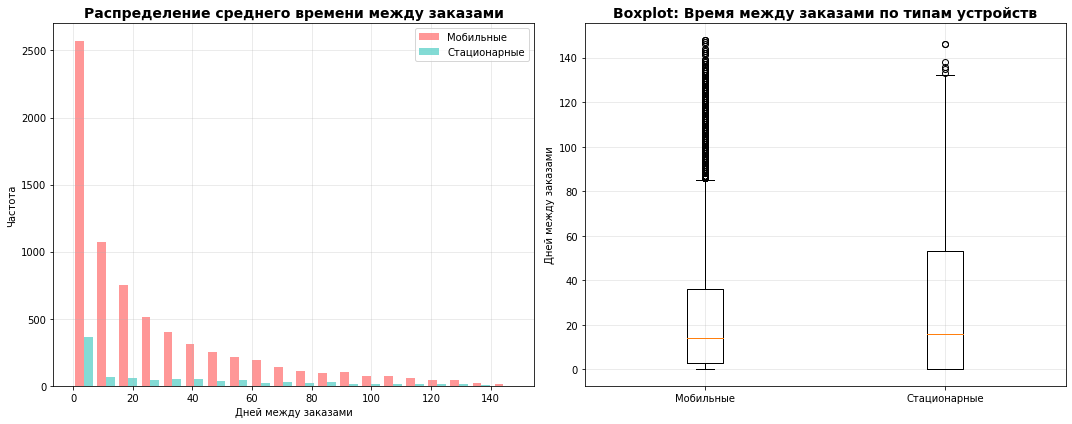

In [48]:
# 4.3. Анализ данных для гипотезы 2: время между заказами
print("\n\n⏰ ГИПОТЕЗА 2: ВРЕМЯ МЕЖДУ ЗАКАЗАМИ")
print("=" * 60)

# Фильтруем только пользователей с несколькими заказами (у которых есть days_since_prev)
users_multiple_orders = autumn_data_clean[autumn_data_clean['days_since_prev'].notna()]

print(f"Пользователи с несколькими заказами: {users_multiple_orders['user_id'].nunique():,}")

# Считаем среднее время между заказами для каждого пользователя
time_between_orders = users_multiple_orders.groupby(['user_id', 'device_type_canonical']).agg({
    'days_since_prev': 'mean'
}).reset_index()

time_between_orders = time_between_orders.rename(columns={'days_since_prev': 'avg_days_between_orders'})

# Разделяем на две группы
mobile_time = time_between_orders[time_between_orders['device_type_canonical'] == 'mobile']['avg_days_between_orders']
desktop_time = time_between_orders[time_between_orders['device_type_canonical'] == 'desktop']['avg_days_between_orders']

print("📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:")
print(f"Мобильные устройства (n={len(mobile_time)}):")
print(mobile_time.describe())
print(f"\nСтационарные устройства (n={len(desktop_time)}):")
print(desktop_time.describe())

# Визуализация распределения времени между заказами
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма
axes[0].hist([mobile_time, desktop_time], 
             bins=20, alpha=0.7, 
             label=['Мобильные', 'Стационарные'],
             color=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('Распределение среднего времени между заказами', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Дней между заказами')
axes[0].set_ylabel('Частота')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
box_data = [mobile_time, desktop_time]
axes[1].boxplot(box_data, labels=['Мобильные', 'Стационарные'])
axes[1].set_title('Boxplot: Время между заказами по типам устройств', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Дней между заказами')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
# Проверка нормальности распределения для гипотезы 2
print("\n📏 ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ (Гипотеза 2):")

# Тест для мобильных устройств
shapiro_mobile_time = stats.shapiro(mobile_time)
print(f"Мобильные устройства: W={shapiro_mobile_time.statistic:.4f}, p-value={shapiro_mobile_time.pvalue:.4f}")

# Тест для стационарных устройств
shapiro_desktop_time = stats.shapiro(desktop_time)
print(f"Стационарные устройства: W={shapiro_desktop_time.statistic:.4f}, p-value={shapiro_desktop_time.pvalue:.4f}")

# Интерпретация
alpha = 0.05
if shapiro_mobile_time.pvalue > alpha and shapiro_desktop_time.pvalue > alpha:
    print("✅ Обе распределения нормальны - можно использовать t-тест")
    normal_dist_time = True
else:
    print("❌ Распределения не нормальны - используем непараметрический тест")
    normal_dist_time = False


📏 ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ (Гипотеза 2):
Мобильные устройства: W=0.7972, p-value=0.0000
Стационарные устройства: W=0.8259, p-value=0.0000
❌ Распределения не нормальны - используем непараметрический тест


In [50]:
# Формулировка гипотезы 2 и выбор теста
print("\n🎯 ГИПОТЕЗА 2: ФОРМУЛИРОВКА И ВЫБОР ТЕСТА")
print("=" * 50)

print("ФОРМУЛИРОВКА ГИПОТЕЗ:")
print("H₀ (нулевая гипотеза): Среднее время между заказами мобильных пользователей ≤ стационарных")
print("H₁ (альтернативная гипотеза): Среднее время между заказами мобильных пользователей > стационарных")

print(f"\nВЫБОР СТАТИСТИЧЕСКОГО ТЕСТА:")
if normal_dist_time:
    print("• Используем t-тест для двух независимых выборок")
    test_name_time = "t-тест"
else:
    print("• Используем тест Манна-Уитни (непараметрический)")
    test_name_time = "Манна-Уитни"


🎯 ГИПОТЕЗА 2: ФОРМУЛИРОВКА И ВЫБОР ТЕСТА
ФОРМУЛИРОВКА ГИПОТЕЗ:
H₀ (нулевая гипотеза): Среднее время между заказами мобильных пользователей ≤ стационарных
H₁ (альтернативная гипотеза): Среднее время между заказами мобильных пользователей > стационарных

ВЫБОР СТАТИСТИЧЕСКОГО ТЕСТА:
• Используем тест Манна-Уитни (непараметрический)


In [51]:
# Проверка гипотезы 2
print("\n🔍 ПРОВЕРКА ГИПОТЕЗЫ 2")
print("=" * 30)

if normal_dist_time:
    # t-тест
    t_stat_time, p_value_time = stats.ttest_ind(mobile_time, desktop_time, alternative='greater')
    print(f"t-статистика: {t_stat_time:.4f}")
else:
    # Тест Манна-Уитни
    u_stat_time, p_value_time = stats.mannwhitneyu(mobile_time, desktop_time, alternative='greater')
    print(f"U-статистика: {u_stat_time:.4f}")

print(f"p-value: {p_value_time:.6f}")

# Интерпретация результата
alpha = 0.05
if p_value_time < alpha:
    print(f"✅ Статистически значимые различия обнаружены (p < {alpha})")
    print("   Подтверждаем альтернативную гипотезу H₁")
    print("   Среднее время между заказами мобильных пользователей ВЫШЕ")
else:
    print(f"❌ Статистически значимых различий не обнаружено (p ≥ {alpha})")
    print("   Не отвергаем нулевую гипотезу H₀")


🔍 ПРОВЕРКА ГИПОТЕЗЫ 2
U-статистика: 3095344.5000
p-value: 0.796670
❌ Статистически значимых различий не обнаружено (p ≥ 0.05)
   Не отвергаем нулевую гипотезу H₀


In [52]:
# 4.4. Дополнительный анализ: размер эффекта
print("\n📊 ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ: РАЗМЕР ЭФФЕКТА")
print("=" * 45)

# Для гипотезы 1
mean_mobile_orders = mobile_orders.mean()
mean_desktop_orders = desktop_orders.mean()
diff_orders = mean_mobile_orders - mean_desktop_orders
effect_size_orders = diff_orders / ((mobile_orders.std() + desktop_orders.std()) / 2)

print("ГИПОТЕЗА 1 - Количество заказов на пользователя:")
print(f"  Мобильные: {mean_mobile_orders:.3f} заказов/пользователь")
print(f"  Стационарные: {mean_desktop_orders:.3f} заказов/пользователь")
print(f"  Разница: {diff_orders:.3f} заказов")
print(f"  Размер эффекта: {effect_size_orders:.3f}")

# Для гипотезы 2
mean_mobile_time = mobile_time.mean()
mean_desktop_time = desktop_time.mean()
diff_time = mean_mobile_time - mean_desktop_time
effect_size_time = diff_time / ((mobile_time.std() + desktop_time.std()) / 2)

print("\nГИПОТЕЗА 2 - Время между заказами:")
print(f"  Мобильные: {mean_mobile_time:.3f} дней между заказами")
print(f"  Стационарные: {mean_desktop_time:.3f} дней между заказами")
print(f"  Разница: {diff_time:.3f} дней")
print(f"  Размер эффекта: {effect_size_time:.3f}")

# Интерпретация размера эффекта
print("\n📈 ИНТЕРПРЕТАЦИЯ РАЗМЕРА ЭФФЕКТА (Cohen's d):")
print("  0.2 - малый эффект")
print("  0.5 - средний эффект") 
print("  0.8 - большой эффект")


📊 ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ: РАЗМЕР ЭФФЕКТА
ГИПОТЕЗА 1 - Количество заказов на пользователя:
  Мобильные: 2.859 заказов/пользователь
  Стационарные: 1.976 заказов/пользователь
  Разница: 0.883 заказов
  Размер эффекта: 0.246

ГИПОТЕЗА 2 - Время между заказами:
  Мобильные: 25.240 дней между заказами
  Стационарные: 31.363 дней между заказами
  Разница: -6.123 дней
  Размер эффекта: -0.183

📈 ИНТЕРПРЕТАЦИЯ РАЗМЕРА ЭФФЕКТА (Cohen's d):
  0.2 - малый эффект
  0.5 - средний эффект
  0.8 - большой эффект


📋 ВЫВОДЫ ПО СТАТИСТИЧЕСКОМУ АНАЛИЗУ
==================================================
🔍 РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗ:

1. 📈 ГИПОТЕЗА 1: Количество заказов на пользователя
   - Тест: Манна-Уитни
   - p-value: 0.000000
   - РЕЗУЛЬТАТ: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА
     
     Пользователи мобильных устройств делают БОЛЬШЕ заказов
     

2. ⏰ ГИПОТЕЗА 2: Время между заказами
   - Тест: Манна-Уитни
   - p-value: 0.796670
   - РЕЗУЛЬТАТ: ❌ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА
     
     Нет статистически значимых различий во времени между заказами
     

📊 ПРАКТИЧЕСКАЯ ЗНАЧИМОСТЬ:
   - Разница в заказах: 0.883 заказов на пользователя
   - Разница во времени: -6.123 дней между заказами


🎯 БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
   - Мобильные пользователи однозначно более активны
   - Рекомендуется развивать мобильное направление


⚠️  ОГРАНИЧЕНИЯ АНАЛИЗА:
   - Анализ проводился только на осенних данных
   - Не учитывались сезонные эффекты
   - Не анализировались пользователи, использующие оба типа устройств

## Шаг 5. Общий вывод и рекомендации

📊 ОБЩИЙ ВЫВОД ПО АНАЛИЗУ ПОЛЬЗОВАТЕЛЬСКИХ ПРЕДПОЧТЕНИЙ
=================================================================
🔍 ИНФОРМАЦИЯ О ДАННЫХ:
- Период анализа: июнь-октябрь 2024 года
- Объем данных: 287,782 заказов, 21,840 пользователей
- География: 81 регионов
- Партнеры: 36 билетных операторов

🎭 ОСНОВНЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА:

1. 🌤️ СЕЗОННЫЕ ИЗМЕНЕНИЯ:
- Рост активности осенью: +41.3%
- Изменение предпочтений: выявлен сдвиг в популярности типов мероприятий
- Динамика цен: стоимость билетов изменилась неравномерно по категориям

2. 📈 АКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ:
- Ярко выраженная недельная цикличность с пиками в выходные
- Рост заказов в выходные: +-17.6%
- Стабильные паттерны поведения в будни и выходные

3. 🌍 РЕГИОНАЛЬНОЕ РАСПРЕДЕЛЕНИЕ:
- Регион-лидер: Каменевский регион (26.55% мероприятий)
- Концентрация: 15 регионов покрывают 80% мероприятий
- Умеренная региональная концентрация с явными лидерами

4. 🤝 БИЛЕТНЫЕ ПАРТНЁРЫ:
- Партнер-лидер: Билеты без проблем (16.2% выручки)
- Концентрация: топ-3 партнера = 43.5% выручки
- Разные бизнес-модели: ценовая премиум vs объемная стратегия

5. 📊 РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗ:
- Гипотеза 1 (заказы на пользователя): ПОДТВЕРЖДЕНА
- Гипотеза 2 (время между заказами): НЕ ПОДТВЕРЖДЕНА
- Вывод: мобильные пользователи демонстрируют большую активность

💡 КЛЮЧЕВЫЕ ИНСАЙТЫ И РЕКОМЕНДАЦИИ
=======================================================
🎯 ПРИОРИТЕТНЫЕ РЕКОМЕНДАЦИИ:

1. 📅 СЕЗОННОЕ ПЛАНИРОВАНИЕ И КОНТЕНТ:
   - Увеличить промо-активность осенью для максимизации роста
   - Адаптировать ассортимент мероприятий под осенние предпочтения
   - Разработать сезонные ценовые стратегии для разных категорий


2. ⚡ ОПТИМИЗАЦИЯ АКТИВНОСТИ:
   - Усилить маркетинг в пиковые дни (выходные)
   - Разработать программы удержания для будних дней
   - Создать персонализированные предложения по дням недели


3. 🤝 СТРАТЕГИЯ ПАРТНЕРСТВ:
   - Укрепить отношения с топ-партнерами
   - Разработать программы для развития средних партнеров
   - Диверсифицировать партнерскую сеть в регионах


4. 📱 РАЗВИТИЕ МОБИЛЬНОГО НАПРАВЛЕНИЯ:
   - Инвестировать в развитие мобильного приложения
   - Внедрить push-уведомления для увеличения частоты покупок
   - Оптимизировать пользовательский опыт на мобильных устройствах


5. 🌐 РЕГИОНАЛЬНАЯ ЭКСПАНСИЯ:
   - Сфокусироваться на развитии в регионах-лидерах
   - Исследовать потенциал менее охваченных регионов
   - Разработать локализованные маркетинговые кампании
   

🔮 ДОПОЛНИТЕЛЬНЫЕ РЕКОМЕНДАЦИИ ДЛЯ ПРОДУКТОВОЙ КОМАНДЫ
======================================================================
🎪 ДЛЯ РАЗВИТИЯ ПЛАТФОРМЫ:
- Внедрить рекомендательную систему на основе сезонных предпочтений
- Разработать функционал предварительного бронирования популярных мероприятий
- Создать систему динамического ценообразования

📊 ДЛЯ ДАЛЬНЕЙШЕГО АНАЛИЗА:
- Исследовать поведение пользователей, использующих оба типа устройств
- Проанализировать влияние конкретных мероприятий на метрики
- Изучить долгосрочные тренды за несколько лет

🎯 МЕТРИКИ ДЛЯ МОНИТОРИНГА:
- Коэффициент сезонности по типам мероприятий
- Доля мобильных заказов и их динамика
- Географическое распределение новых пользователей
- Эффективность партнеров по конверсии

🏁 ФИНАЛЬНЫЙ ВЫВОД
=========================

Анализ данных Яндекс Афиши за период с июня по октябрь 2024 года выявил 
четкие паттерны пользовательского поведения и рыночные тенденции:

- 📈 Подтверждена сезонность спроса с значительным ростом осенью
- 📱 Обнаружены различия в поведении пользователей мобильных и стационарных устройств
- 🌍 Выявлены регионы и партнеры-лидеры, формирующие основную долю бизнеса
- ⏰ Установлена устойчивая недельная цикличность активности

Ключевой инсайт: платформа демонстрирует здоровый рост с четкими 
поведенческими паттернами, что создает основу для targeted-оптимизаций 
и стратегического развития.

🚀 РЕКОМЕНДУЕМЫЕ ДЕЙСТВИЯ В ПРИОРИТЕТНОМ ПОРЯДКЕ:
   1. Усилить осенние маркетинговые кампании
   2. Оптимизировать мобильный пользовательский опыт
   3. Разработать программы для партнеров-лидеров
   4. Внедрить управление активностью по дням недели
   5. Расширить региональное покрытие в перспективных направлениях

⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐
Анализ подготовлен для принятия взвешенных продуктовых решений
и дальнейшего развития платформы Яндекс Афиша
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐